# Information Extraction

In [1]:
%load_ext autoreload
%autoreload 2

# Run this code cell to set notebook width
from IPython.display import display, HTML
display(HTML("<style>.container { width:95%; }</style>"))

## Import Libraries

In [2]:
import sys
sys.path.append('..')

import warnings
warnings.filterwarnings("ignore")

import os
import re
import cv2
import copy
import glob
import json
import torch
import string
import random
import mlflow
import numpy as np
import torchmetrics
import pandas as pd
import networkx as nx
import torch.nn as nn
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm import tqdm
from datetime import datetime
from dateutil.parser import parse
from sklearn.manifold import TSNE
from difflib import SequenceMatcher
from torch.optim.lr_scheduler import CyclicLR
from torch_geometric.data import Data as G_Data
from torch_geometric.nn import GCNConv, ChebConv
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score
from pytorch_lightning.loggers import TensorBoardLogger
from torch_geometric.data import LightningDataset as G_LightningDataset
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor

from config import config as conf
random.seed(42)

In [3]:
# Set tracking URI
mlflow.set_tracking_uri(uri=os.getenv('TRACKING_URI', 'http://localhost:5000'))

## Data Pre-Processing, Visualization and Loader Definition

In [4]:
def get_raw_data_df(dirs, is_train=True, save_path='../../../data/processed/information-extraction', save_file_name='data.csv', columns=['file_path', 'image', 'txt', 'is_train', 'is_test']):
    data = []
    for dir_path in dirs:
        print(f"Fetching data from {dir_path}")
        files = glob.glob(dir_path + "/*.jpg")
        for file in files:
            file_name = file.split('/')[-1].split('.')[0]
            if os.path.exists(os.path.join(dir_path, file_name+'.txt')):
                data.append([
                    dir_path,
                    file_name+'.jpg',
                    file_name+'.txt',
                    int(is_train),
                    int(not is_train)
                ])
    df = pd.DataFrame(data, columns=columns)
    df.to_csv(os.path.join(save_path, save_file_name))
    return df

df_ocr = pd.concat([get_raw_data_df(dirs=conf.DATA_TRAIN_OCR_ENGINE, save_path=conf.DATA_DIR_PROCESSED, save_file_name='raw_train_orc.csv'), get_raw_data_df(dirs=conf.DATA_TEST, is_train=False, save_path=conf.DATA_DIR_PROCESSED, save_file_name='raw_test_ocr.csv')]).reset_index(drop=True)
print(f"\nTrain data length = {df_ocr['is_train'].value_counts()[1]}\nTest data length = {df_ocr['is_train'].value_counts()[0]}")
df_ocr

Fetching data from ../../../data/raw/train-1
Fetching data from ../../../data/raw/test-1

Train data length = 704
Test data length = 360


,file_path,image,txt,is_train,is_test
0,../../../data/raw/train-1,X51005719917.jpg,X51005719917.txt,1,0
1,../../../data/raw/train-1,X51006556818.jpg,X51006556818.txt,1,0
2,../../../data/raw/train-1,X00016469612.jpg,X00016469612.txt,1,0
3,../../../data/raw/train-1,X00016469619.jpg,X00016469619.txt,1,0
4,../../../data/raw/train-1,X00016469620.jpg,X00016469620.txt,1,0
...,...,...,...,...,...
1059,../../../data/raw/test-1,X51009008091.jpg,X51009008091.txt,0,1
1060,../../../data/raw/test-1,X51009008095.jpg,X51009008095.txt,0,1
1061,../../../data/raw/test-1,X51009447842.jpg,X51009447842.txt,0,1
1062,../../../data/raw/test-1,X51009453729.jpg,X51009453729.txt,0,1


In [5]:
df_ie = get_raw_data_df(dirs=conf.DATA_TRAIN_IE, save_path=conf.DATA_DIR_PROCESSED, save_file_name='raw_train_ie.csv', columns=['ie_file_path', 'image', 'txt', 'is_train', 'is_test'])
print(f"\nTrain data length= {df_ie['is_train'].value_counts()[1]}")
df_ie

Fetching data from ../../../data/raw/train-2

Train data length= 727


,ie_file_path,image,txt,is_train,is_test
0,../../../data/raw/train-2,X00016469612.jpg,X00016469612.txt,1,0
1,../../../data/raw/train-2,X00016469619.jpg,X00016469619.txt,1,0
2,../../../data/raw/train-2,X00016469620.jpg,X00016469620.txt,1,0
3,../../../data/raw/train-2,X00016469622.jpg,X00016469622.txt,1,0
4,../../../data/raw/train-2,X00016469623.jpg,X00016469623.txt,1,0
...,...,...,...,...,...
722,../../../data/raw/train-2,X51007339164.jpg,X51007339164.txt,1,0
723,../../../data/raw/train-2,X51007339165.jpg,X51007339165.txt,1,0
724,../../../data/raw/train-2,X51007339166(1).jpg,X51007339166(1).txt,1,0
725,../../../data/raw/train-2,X51007339166(2).jpg,X51007339166(2).txt,1,0


In [6]:
df_ocr_merged = df_ocr.merge(df_ie[['ie_file_path', 'image', 'txt']], how='left', on=['image', 'txt'])
df_ocr_merged = df_ocr_merged[['file_path', 'ie_file_path', 'image', 'txt', 'is_train', 'is_test']]
df_ocr_merged['is_test_with_label'] = 0
for i in random.choices(df_ocr_merged[(df_ocr_merged['is_test'] == 0) & (~df_ocr_merged['ie_file_path'].isnull())].index.to_list(), k=10):
    df_ocr_merged.at[i, 'is_test_with_label'] = 1
df_ocr_merged

,file_path,ie_file_path,image,txt,is_train,is_test,is_test_with_label
0,../../../data/raw/train-1,../../../data/raw/train-2,X51005719917.jpg,X51005719917.txt,1,0,0
1,../../../data/raw/train-1,../../../data/raw/train-2,X51006556818.jpg,X51006556818.txt,1,0,0
2,../../../data/raw/train-1,../../../data/raw/train-2,X00016469612.jpg,X00016469612.txt,1,0,0
3,../../../data/raw/train-1,../../../data/raw/train-2,X00016469619.jpg,X00016469619.txt,1,0,0
4,../../../data/raw/train-1,../../../data/raw/train-2,X00016469620.jpg,X00016469620.txt,1,0,0
...,...,...,...,...,...,...,...
1059,../../../data/raw/test-1,NaN,X51009008091.jpg,X51009008091.txt,0,1,0
1060,../../../data/raw/test-1,NaN,X51009008095.jpg,X51009008095.txt,0,1,0
1061,../../../data/raw/test-1,NaN,X51009447842.jpg,X51009447842.txt,0,1,0
1062,../../../data/raw/test-1,NaN,X51009453729.jpg,X51009453729.txt,0,1,0


In [7]:
df_ocr_merged[df_ocr_merged['is_test_with_label'] == 1]

,file_path,ie_file_path,image,txt,is_train,is_test,is_test_with_label
16,../../../data/raw/train-1,../../../data/raw/train-2,X51006679222.jpg,X51006679222.txt,1,0,1
19,../../../data/raw/train-1,../../../data/raw/train-2,X51006733494.jpg,X51006733494.txt,1,0,1
61,../../../data/raw/train-1,../../../data/raw/train-2,X51005676545.jpg,X51005676545.txt,1,0,1
150,../../../data/raw/train-1,../../../data/raw/train-2,X51008030560.jpg,X51008030560.txt,1,0,1
184,../../../data/raw/train-1,../../../data/raw/train-2,X51007339642.jpg,X51007339642.txt,1,0,1
292,../../../data/raw/train-1,../../../data/raw/train-2,X51005745214.jpg,X51005745214.txt,1,0,1
456,../../../data/raw/train-1,../../../data/raw/train-2,X51005442383.jpg,X51005442383.txt,1,0,1
482,../../../data/raw/train-1,../../../data/raw/train-2,X51005433553.jpg,X51005433553.txt,1,0,1
522,../../../data/raw/train-1,../../../data/raw/train-2,X51005361900(1).jpg,X51005361900(1).txt,1,0,1
630,../../../data/raw/train-1,../../../data/raw/train-2,X51006619496.jpg,X51006619496.txt,1,0,1


In [8]:
def strip_string(s):
    return s.strip()

def resize_point(image_width, image_height, point, size=(720, 1080)):
    new_w, new_h = size
    ratio_w = new_w / image_width
    ratio_h = new_h / image_height
    return (point[0] * ratio_w, point[1] * ratio_h)

In [9]:
def get_normalized_entities(record):
    image = cv2.imread(os.path.join(record['file_path'], record['image']))
    h, w = image.shape[:2]
    x_coords, y_coords = [], []
    with open(os.path.join(record['file_path'], record['txt']), errors='ignore') as f:
        lines = f.readlines()
    for line in lines:
        line_content = list(map(strip_string, line.split(',')))
        for i in line_content[:8][0::2]:
            x_coords.append(int(i))
        for i in line_content[:8][1::2]:
            y_coords.append(int(i))
    record['doc_xmin'] = min(x_coords)
    record['doc_xmax'] = max(x_coords)
    record['doc_ymin'] = min(y_coords)
    record['doc_ymax'] = max(y_coords)
    record['width'] = w
    record['height'] = h
    record['normalized_width'] = max(x_coords) - min(x_coords)
    record['normalized_height'] = max(y_coords) - min(y_coords)
    return record

if os.path.exists(conf.DATA_DIR_PROCESSED + '/interim-normalized-data.csv'):
    df_ocr_merged = pd.read_csv(conf.DATA_DIR_PROCESSED + '/interim-normalized-data.csv')
else:
    df_ocr_merged = df_ocr_merged.apply(get_normalized_entities, axis=1) 
    df_ocr_merged.to_csv(conf.DATA_DIR_PROCESSED + '/interim-normalized-data.csv', index=False)

df_ocr_merged

,file_path,ie_file_path,image,txt,is_train,is_test,is_test_with_label,doc_xmin,doc_xmax,doc_ymin,doc_ymax,width,height,normalized_width,normalized_height
0,../../../data/raw/train-1,../../../data/raw/train-2,X51005719917.jpg,X51005719917.txt,1,0,0,101,868,137,2609,932,2679,767,2472
1,../../../data/raw/train-1,../../../data/raw/train-2,X51006556818.jpg,X51006556818.txt,1,0,0,18,587,67,1158,616,1200,569,1091
2,../../../data/raw/train-1,../../../data/raw/train-2,X00016469612.jpg,X00016469612.txt,1,0,0,27,443,25,977,463,1013,416,952
3,../../../data/raw/train-1,../../../data/raw/train-2,X00016469619.jpg,X00016469619.txt,1,0,0,16,400,50,958,439,1004,384,908
4,../../../data/raw/train-1,../../../data/raw/train-2,X00016469620.jpg,X00016469620.txt,1,0,0,14,436,47,899,459,949,422,852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1059,../../../data/raw/test-1,NaN,X51009008091.jpg,X51009008091.txt,0,1,0,35,699,93,1645,746,1824,664,1552
1060,../../../data/raw/test-1,NaN,X51009008095.jpg,X51009008095.txt,0,1,0,65,674,150,1241,744,1286,609,1091
1061,../../../data/raw/test-1,NaN,X51009447842.jpg,X51009447842.txt,0,1,0,86,864,184,1675,928,1769,778,1491
1062,../../../data/raw/test-1,NaN,X51009453729.jpg,X51009453729.txt,0,1,0,10,524,21,913,615,931,514,892


In [10]:
def get_label(text_set, label_dict):
    for k, v in label_dict.items():
        cleaned_value_set = v.replace(',', '').strip().split()
        matches = 0
        for i in text_set:
            if any(SequenceMatcher(a=re.sub(r'[^\w]', '', i), b=re.sub(r'[^\w]', '', j)).ratio() > 0.8 for j in cleaned_value_set if len(i) > 1):
                matches += 1
            if (matches / len(text_set)) >= 0.75 or matches == len(cleaned_value_set):
                return k.upper().strip()
    return "OTHERS"
    
def prepare_df(df, resize=(conf.RESIZE_WIDTH, conf.RESIZE_HEIGHT), save_path=conf.DATA_DIR_PROCESSED, save_file_name='processed-data.csv'):
    data = []
    for ind, row in tqdm(df.iterrows()):
        base_data = [
            row['file_path'],
            row['ie_file_path'],
            row['image'],
            row['txt'],
            row['width'],
            row['height'],
            row['normalized_width'],
            row['normalized_height'],
            row['doc_xmin'],
            row['doc_xmax'],
            row['doc_ymin'],
            row['doc_ymax'],
            row['is_train'],
            row['is_test'],
            row['is_test_with_label']
        ]
        with open(os.path.join(row['file_path'], row['txt']), errors='ignore') as f:
            lines = f.readlines()
        if type(row['ie_file_path']) is str:
            with open(os.path.join(row['ie_file_path'], row['txt']), errors='ignore') as f:
                label_lines = f.readlines()
            label_lines = [i.strip() for i in label_lines]
            ie_string = ''.join(label_lines)
            ie_data = json.loads(ie_string)
        else:
            ie_data = None
        for line in lines:
            label = None
            normalized_annotation = []
            line_content = list(map(strip_string, line.split(',')))
            coord_content = list(map(int, line_content[:8]))
            for ind, coord in enumerate(coord_content):
                if ind % 2 == 0:
                    coord -= row['doc_xmin']
                else:
                    coord -= row['doc_ymin']
                normalized_annotation.append(coord)
            text = ', '.join(line_content[8:])
            text_set = text.replace(",", "").strip().split()
            if ie_data:
                label = get_label(text_set, ie_data)
            else:
                label = np.NaN
            r_x1, r_y1 = resize_point(row['normalized_width'], row['normalized_height'], (normalized_annotation[0], normalized_annotation[1]), resize)
            r_x2, r_y2 = resize_point(row['normalized_width'], row['normalized_height'], (normalized_annotation[2], normalized_annotation[3]), resize)
            r_x3, r_y3 = resize_point(row['normalized_width'], row['normalized_height'], (normalized_annotation[4], normalized_annotation[5]), resize)
            r_x4, r_y4 = resize_point(row['normalized_width'], row['normalized_height'], (normalized_annotation[6], normalized_annotation[7]), resize)
            resized_annotations = [r_x1, r_y1, r_x2, r_y2, r_x3, r_y3, r_x4, r_y4]
            normalized_resized_annotations = [r_x1/resize[0], r_y1/resize[1], r_x2/resize[0], r_y2/resize[1], r_x3/resize[0], r_y3/resize[1], r_x4/resize[0], r_y4/resize[1]]
            derived_data = coord_content + normalized_annotation + resized_annotations + normalized_resized_annotations + [resize[0], resize[1]] + [text] + [label]
            data.append(
                base_data + derived_data
            )
    res = pd.DataFrame(data, columns=
        ['file_path', 'ie_file_path', 'image', 'txt', 'width', 'height', 'normalized_width', 'normalized_height', 'doc_xmin', 'doc_xmax', 'doc_ymin', 'doc_ymax', 'is_train', 'is_test', 'is_test_with_label']
      + ['x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4', 'n_x1', 'n_y1', 'n_x2', 'n_y2', 'n_x3', 'n_y3', 'n_x4', 'n_y4', 'r_x1', 'r_y1', 'r_x2', 'r_y2', 'r_x3', 'r_y3', 'r_x4', 'r_y4', 'n_r_x1', 'n_r_y1', 'n_r_x2', 'n_r_y2', 'n_r_x3', 'n_r_y3', 'n_r_x4', 'n_r_y4', 'resize_width', 'resize_height', 'text', 'label_names']  
    )
    res['label'] = res['label_names'].apply(lambda x: conf.LABEL[x] if type(x) is str else np.NAN)
    res.to_csv(os.path.join(save_path, save_file_name), index=False)
    return res

if os.path.exists(conf.DATA_DIR_PROCESSED + '/processed-data.csv'):
    df_ocr_processed = pd.read_csv(conf.DATA_DIR_PROCESSED + '/processed-data.csv')
else:
    df_ocr_processed = prepare_df(df_ocr_merged)

df_ocr_processed

,file_path,ie_file_path,image,txt,width,height,normalized_width,normalized_height,doc_xmin,doc_xmax,...,n_r_y2,n_r_x3,n_r_y3,n_r_x4,n_r_y4,resize_width,resize_height,text,label_names,label
0,../../../data/raw/train-1,../../../data/raw/train-2,X51005719917.jpg,X51005719917.txt,932,2679,767,2472,101,868,...,0.000000,0.621904,0.010922,0.349413,0.010922,720,1080,TAX INVOICE,OTHERS,0.0
1,../../../data/raw/train-1,../../../data/raw/train-2,X51005719917.jpg,X51005719917.txt,932,2679,767,2472,101,868,...,0.016990,0.658409,0.028722,0.320730,0.028722,720,1080,DOMINO'S PIZZA,OTHERS,0.0
2,../../../data/raw/train-1,../../../data/raw/train-2,X51005719917.jpg,X51005719917.txt,932,2679,767,2472,101,868,...,0.040049,0.816167,0.052994,0.168188,0.052994,720,1080,GST REF NO : 001694261248,OTHERS,0.0
3,../../../data/raw/train-1,../../../data/raw/train-2,X51005719917.jpg,X51005719917.txt,932,2679,767,2472,101,868,...,0.060680,0.786180,0.071602,0.183833,0.071602,720,1080,DOMINO'S PIZZA SEGAMBUT,OTHERS,0.0
4,../../../data/raw/train-1,../../../data/raw/train-2,X51005719917.jpg,X51005719917.txt,932,2679,767,2472,101,868,...,0.079693,0.857888,0.093851,0.121252,0.093851,720,1080,"D-08, M AVENUE, JLN 1 / 38A",OTHERS,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56891,../../../data/raw/test-1,NaN,X51009568881.jpg,X51009568881.txt,884,1678,769,1347,45,814,...,0.874536,0.475943,0.896808,0.386216,0.896808,720,1080,9.81,NaN,NaN
56892,../../../data/raw/test-1,NaN,X51009568881.jpg,X51009568881.txt,884,1678,769,1347,45,814,...,0.873794,0.706112,0.899035,0.615085,0.899035,720,1080,0.59,NaN,NaN
56893,../../../data/raw/test-1,NaN,X51009568881.jpg,X51009568881.txt,884,1678,769,1347,45,814,...,0.874536,0.966190,0.898293,0.859558,0.898293,720,1080,10.40,NaN,NaN
56894,../../../data/raw/test-1,NaN,X51009568881.jpg,X51009568881.txt,884,1678,769,1347,45,814,...,0.933927,0.958388,0.971789,0.006502,0.971789,720,1080,THANK YOU ! & PLEASE COME AGAIN !!,NaN,NaN


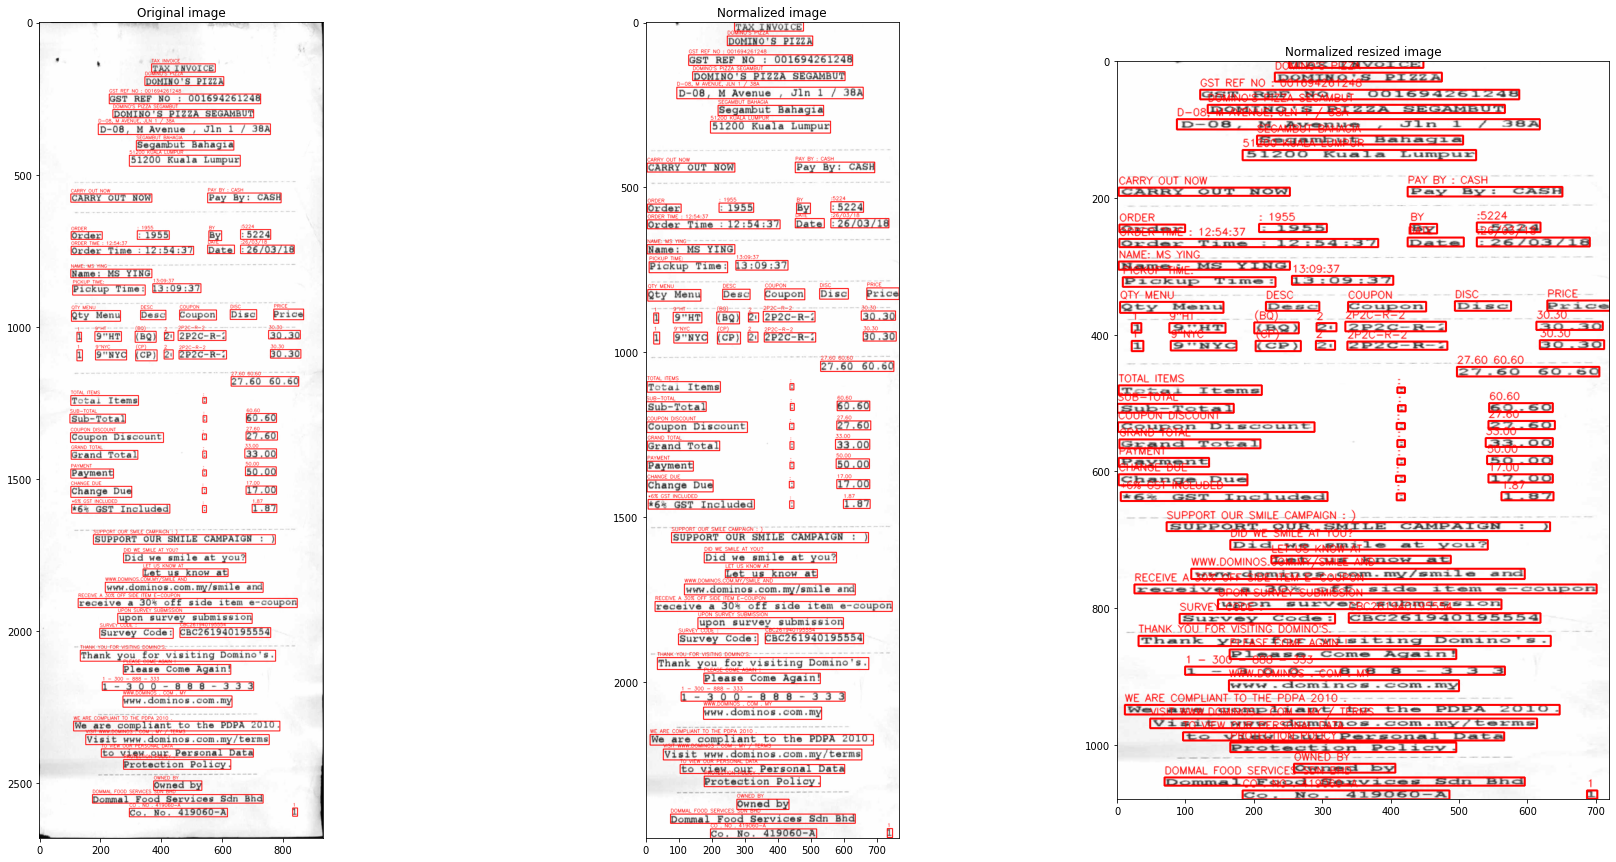

In [11]:
def plot_normalized_record(df, resize=(conf.RESIZE_WIDTH, conf.RESIZE_HEIGHT)):
    assert len(df['doc_xmin'].unique().tolist()) == 1 and len(df['doc_ymin'].unique().tolist()) == 1 and len(df['doc_xmax'].unique().tolist()) == 1 and len(df['doc_ymax'].unique().tolist()) == 1, 'df must have only one xmin, ymin, xmax and ymax values per document.'
    xmin, ymin, xmax, ymax = df['doc_xmin'].unique().tolist()[0], df['doc_ymin'].unique().tolist()[0], df['doc_xmax'].unique().tolist()[0], df['doc_ymax'].unique().tolist()[0]
    image = cv2.imread(os.path.join(df.iloc[0]['file_path'], df.iloc[0]['image']))
    image_copy = copy.deepcopy(image[ymin: ymax, xmin: xmax, :])
    image_resize = cv2.resize(image_copy, resize)
    for ind, row in df.iterrows():
        image = cv2.rectangle(image, (int(row['x1']), int(row['y1'])), (int(row['x3']), int(row['y3'])), (255, 0, 0), 2)
        image = cv2.putText(image, row['text'], (int(row['x1']), int(row['y1'])-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1, cv2.LINE_AA)
        image_copy = cv2.rectangle(image_copy, (int(row['n_x1']), int(row['n_y1'])), (int(row['n_x3']), int(row['n_y3'])), (255, 0, 0), 2)
        image_copy = cv2.putText(image_copy, row['text'], (int(row['n_x1']), int(row['n_y1'])-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1, cv2.LINE_AA)
        image_resize = cv2.rectangle(image_resize, (int(row['r_x1']), int(row['r_y1'])), (int(row['r_x3']), int(row['r_y3'])), (255, 0, 0), 2)
        image_resize = cv2.putText(image_resize, row['text'], (int(row['r_x1']), int(row['r_y1'])-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1, cv2.LINE_AA)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,15))
    ax1.imshow(image)
    ax1.set_title("Original image")
    ax2.imshow(image_copy)
    ax2.set_title("Normalized image")
    ax3.imshow(image_resize)
    ax3.set_title("Normalized resized image")

plot_normalized_record(df_ocr_processed[df_ocr_processed['image']=='X51005719917.jpg'])

0.0    29433
4.0     1787
1.0     1607
3.0      778
2.0      731
Name: label, dtype: int64


<AxesSubplot:title={'center':'Label count across docs -> n = 642'}>

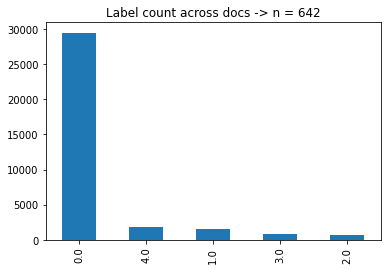

In [12]:
df_dataset = copy.deepcopy(df_ocr_processed[(~df_ocr_processed['label'].isnull()) & (df_ocr_processed['is_test_with_label'] != 1)])
print(df_dataset['label'].value_counts())
df_dataset['label'].value_counts().plot(kind='bar', title=f"Label count across docs -> n = {df_dataset['image'].nunique()}")

In [13]:
# Refer - https://github.com/dhavalpotdar/Graph-Convolution-on-Structured-Documents/blob/7400704346cb9698f6c6b1ad3307d2439d17fa33/grapher.py#L11
class Graph:
    
    def __init__(self, df, max_nodes=100, columns=['r_x1', 'r_y1', 'r_x3', 'r_y3', 'text'], label='label'):
        self.df = df
        self.df.reset_index(inplace=True)
        self.max_nodes = max_nodes
        self.xmin, self.ymin, self.xmax, self.ymax, self.text = columns
        self.label = label
        self.special_chars = {i: ind for ind, i in enumerate(string.punctuation)}
    
    def get_features(self):
        
        def is_aplha(s):
            return int(s.isalpha())

        def is_numeric(s):
            return int(s.isnumeric())

        def is_alnum(s):
            return int(s.isalnum())

        def is_decimal_number(s):
            return int(bool(re.match("[\d.\d]+$", s)))

        def is_number_with_symbols(s):
            return int(bool(re.match("[\d{}]+$".format(re.escape(string.punctuation)), s)))

        def is_date(s, fuzzy=False):
            try: 
                parse(s, fuzzy=fuzzy)
                return 1
            except (ValueError, OverflowError):
                return 0
        
        feats = []
        for ind, row in self.df.iterrows():
            is_char_upper, is_char_lower, is_char_alpha, is_char_digit, is_char_space = 0, 0, 0, 0, 0
            is_char_special = [0] * len(self.special_chars)
            is_word_alpha, is_word_numeric, is_word_alnum, is_word_decimal_number, is_word_number_with_symbol, is_word_date = 0, 0, 0, 0, 0, 0
            for c in row['text']:
                if c.islower(): is_char_lower += 1
                if c.isupper(): is_char_upper += 1
                if c.isalpha(): is_char_alpha += 1
                if c.isnumeric(): is_char_digit += 1
                if c.isspace(): is_char_space += 1
                if c in self.special_chars.keys():
                    is_char_special[self.special_chars[c]] += 1
            for word in row['text'].split():
                is_word_alpha += is_aplha(word)
                is_word_numeric += is_numeric(word)
                is_word_alnum += is_alnum(word)
                is_word_decimal_number += is_decimal_number(word)
                is_word_number_with_symbol += is_number_with_symbols(word)
                is_word_date += is_date(word)
            feat = [is_char_upper, is_char_lower, is_char_alpha, is_char_digit, is_char_space] + \
                   is_char_special + \
                   [is_word_alpha, is_word_numeric, is_word_alnum, is_word_decimal_number, is_word_number_with_symbol, is_word_date] + \
                   [row['n_r_x1'], row['n_r_y1'], row['n_r_x2'], row['n_r_y2'], row['n_r_x3'], row['n_r_x3'], row['n_r_x4'], row['n_r_y4']]
            feats.append(feat)
        return np.asarray(feats)
    
    def pad_adj(self, adj_matrix):
        n = adj_matrix.shape[0]
        target = np.zeros((self.max_nodes, self.max_nodes))
        if n < self.max_nodes:
            target[:n, :n] = adj_matrix
        elif n > self.max_nodes:
            target = adj_matrix[:self.max_nodes, :self.max_nodes]
        else:
            target = adj_matrix
        return target
    
    def pad_feats(self, feats):
        target = np.zeros((self.max_nodes, feats.shape[1]))
        if feats.shape[0] < self.max_nodes:
            target[:feats.shape[0], :feats.shape[1]] = feats
        elif feats.shape[0] > self.max_nodes:
            target = feats[:self.max_nodes, :feats.shape[1]]
        else:
            target = feats
        return feats
    
    def get_edge_index(self):
        edge_index = []
        node_index = self.df.index.to_list()
        for ind, row in self.df.iterrows():
            if row['vertically_close_object_ids'] in node_index:
                edge_index.append([node_index.index(ind), node_index.index(row['vertically_close_object_ids'])])
                edge_index.append([node_index.index(row['vertically_close_object_ids']), node_index.index(ind)])
            if row['horizontally_close_object_ids'] in  node_index:
                edge_index.append([node_index.index(ind), node_index.index(row['horizontally_close_object_ids'])])
                edge_index.append([node_index.index(row['horizontally_close_object_ids']), node_index.index(ind)])
        return np.asarray(edge_index).T
    
    def get_goemetric_data(self, index, features):
        return G_Data(x=torch.from_numpy(features).float().contiguous(), edge_index=torch.from_numpy(index).type(torch.LongTensor).contiguous(), y=torch.Tensor(self.df[self.label].to_list()).type(torch.LongTensor).contiguous())
        
    def make_graph(self):
        graph = nx.from_dict_of_lists(self.graph_dict)
        adj_matrix_sparse = nx.adjacency_matrix(graph)
        adj_matrix = np.asarray(adj_matrix_sparse.todense())
        padded_adj_matrix = self.pad_adj(adj_matrix)
        feats = self.get_features()
        padded_feats = self.pad_feats(feats)
        edge_index = self.get_edge_index()
        data = self.get_goemetric_data(edge_index, feats)
        return graph, padded_adj_matrix, padded_feats, adj_matrix, edge_index, feats, data
         
    def generate(self):
        distances_vertical, distances_horizontal = [], []
        nearest_dst_ids_vertical, nearest_dst_ids_horizontal = [], []
        x_src_coord_vertical, y_src_coord_vertical, x_dst_coord_vertical, y_dst_coord_vertical = [], [], [], []
        x_src_coord_horizontal, y_src_coord_horizontal, x_dst_coord_horizontal, y_dst_coord_horizontal = [], [], [], []
        for src_ind, src_row in self.df.iterrows():
            dst_attributes_vertical, dst_attributes_horizontal = [], []
            src_x_range = (src_row[self.xmin], src_row[self.xmax])
            src_y_range = (src_row[self.ymin], src_row[self.ymax])
            src_centroid_x = (src_x_range[0] + src_x_range[1]) / 2
            src_centroid_y = (src_y_range[0] + src_y_range[1]) / 2
            for dst_ind, dst_row in self.df.iterrows():
                dst_x_range = (dst_row[self.xmin], dst_row[self.xmax])
                dst_y_range = (dst_row[self.ymin], dst_row[self.ymax])
                dst_centroid_x = (dst_x_range[0] + dst_x_range[1]) / 2
                dst_centroid_y = (dst_y_range[0] + dst_y_range[1]) / 2
                if src_ind != dst_ind:
                    if dst_centroid_y > src_centroid_y:
                        if dst_x_range[0] <= src_x_range[0] and dst_x_range[1] >= src_x_range[1]:
                            x_common = (src_x_range[0] + src_x_range[1]) / 2
                            src_point, dst_point = (x_common, src_centroid_y), (x_common, dst_centroid_y)
                            dst_attributes_vertical.append((dst_ind, src_point, dst_point, dst_centroid_y-src_centroid_y))
                        elif dst_x_range[0] >= src_x_range[0] and dst_x_range[1] <= src_x_range[1]:
                            x_common = (dst_x_range[0] + dst_x_range[1]) / 2
                            src_point, dst_point = (x_common, src_centroid_y), (x_common, dst_centroid_y)
                            dst_attributes_vertical.append((dst_ind, src_point, dst_point, dst_centroid_y-src_centroid_y))
                        elif dst_x_range[0] <= src_x_range[0] and dst_x_range[1] >= src_x_range[0] and dst_x_range[1] <= src_x_range[1]:
                            x_common = (src_x_range[0] + dst_x_range[1]) / 2
                            src_point, dst_point = (x_common, src_centroid_y), (x_common, dst_centroid_y)
                            dst_attributes_vertical.append((dst_ind, src_point, dst_point, dst_centroid_y-src_centroid_y))
                        elif dst_x_range[0] >= src_x_range[0] and dst_x_range[0] <= src_x_range[1] and dst_x_range[1] >= src_x_range[1]:
                            x_common = (dst_x_range[0] + src_x_range[1]) / 2
                            src_point, dst_point = (x_common, src_centroid_y), (x_common, dst_centroid_y)
                            dst_attributes_vertical.append((dst_ind, src_point, dst_point, dst_centroid_y-src_centroid_y))
                if dst_centroid_x > src_centroid_x:
                    if dst_y_range[0] <= src_y_range[0] and dst_y_range[1] >= src_y_range[1]:
                        y_common = (src_y_range[0] + src_y_range[1]) / 2
                        src_point, dst_point = (src_centroid_x, y_common), (dst_centroid_x, y_common)
                        dst_attributes_horizontal.append((dst_ind, src_point, dst_point, dst_centroid_x-src_centroid_x))
                    elif dst_y_range[0] >= src_y_range[0] and dst_y_range[1] <= src_y_range[1]:
                        y_common = (dst_y_range[0] + dst_y_range[1]) / 2
                        src_point, dst_point = (src_centroid_x, y_common), (dst_centroid_x, y_common)
                        dst_attributes_horizontal.append((dst_ind, src_point, dst_point, dst_centroid_x-src_centroid_x))
                    elif dst_y_range[0] <= src_y_range[0] and dst_y_range[1] >= src_y_range[1] and dst_y_range[1] <= src_y_range[1]:
                        y_common = (src_y_range[0] + dst_y_range[1]) / 2
                        src_point, dst_point = (src_centroid_x, y_common), (dst_centroid_x, y_common)
                        dst_attributes_horizontal.append((dst_ind, src_point, dst_point, dst_centroid_x-src_centroid_x))
                    elif dst_y_range[0] >= src_y_range[0] and dst_y_range[0] <= src_y_range[1] and dst_y_range[1] >= src_y_range[1]:
                        y_common = (src_y_range[0] + dst_y_range[1]) / 2
                        src_point, dst_point = (src_centroid_x, y_common), (dst_centroid_x, y_common)
                        dst_attributes_horizontal.append((dst_ind, src_point, dst_point, dst_centroid_x-src_centroid_x))
            dst_attributes_vertical_sorted, dst_attributes_horizontal_sorted = sorted(dst_attributes_vertical, key=lambda x: x[3]), sorted(dst_attributes_horizontal, key=lambda x: x[3])
            if len(dst_attributes_vertical_sorted) == 0:
                nearest_dst_ids_vertical.append(-1)
                x_src_coord_vertical.append(-1)
                y_src_coord_vertical.append(-1)
                x_dst_coord_vertical.append(-1)
                y_dst_coord_vertical.append(-1)
                distances_vertical.append(-1)
            else:
                nearest_dst_ids_vertical.append(dst_attributes_vertical_sorted[0][0])
                x_src_coord_vertical.append(dst_attributes_vertical_sorted[0][1][0])
                y_src_coord_vertical.append(dst_attributes_vertical_sorted[0][1][1])
                x_dst_coord_vertical.append(dst_attributes_vertical_sorted[0][2][0])
                y_dst_coord_vertical.append(dst_attributes_vertical_sorted[0][2][1])
                distances_vertical.append(dst_attributes_vertical_sorted[0][3])
            if len(dst_attributes_horizontal_sorted) == 0:
                nearest_dst_ids_horizontal.append(-1)
                x_src_coord_horizontal.append(-1)
                y_src_coord_horizontal.append(-1)
                x_dst_coord_horizontal.append(-1)
                y_dst_coord_horizontal.append(-1)
                distances_horizontal.append(-1)
            else:
                nearest_dst_ids_horizontal.append(dst_attributes_horizontal_sorted[0][0])
                x_src_coord_horizontal.append(dst_attributes_horizontal_sorted[0][1][0])
                y_src_coord_horizontal.append(dst_attributes_horizontal_sorted[0][1][1])
                x_dst_coord_horizontal.append(dst_attributes_horizontal_sorted[0][2][0])
                y_dst_coord_horizontal.append(dst_attributes_horizontal_sorted[0][2][1])
                distances_horizontal.append(dst_attributes_horizontal_sorted[0][3])
        vertically_close_objects, horizontally_close_objects = [], []
        for i in nearest_dst_ids_vertical:
            if i == -1:
                vertically_close_objects.append('')
            else:
                vertically_close_objects.append(self.df.loc[i, 'text'])
        for i in nearest_dst_ids_horizontal:
            if i == -1:
                horizontally_close_objects.append('')
            else:
                horizontally_close_objects.append(self.df.loc[i, 'text'])
        self.df['vertically_close_objects'] = vertically_close_objects
        self.df['vertically_close_object_ids'] = nearest_dst_ids_vertical
        self.df['vertically_close_object_x_src_coord_centroid'] = x_src_coord_vertical
        self.df['vertically_close_object_y_src_coord_centroid'] = y_src_coord_vertical
        self.df['vertically_close_object_x_dst_coord_centroid'] = x_dst_coord_vertical
        self.df['vertically_close_object_y_dst_coord_centroid'] = y_dst_coord_vertical
        self.df['vertically_close_object_distances'] = distances_vertical
        self.df['horizontally_close_objects'] = horizontally_close_objects
        self.df['horizontally_close_object_ids'] = nearest_dst_ids_horizontal
        self.df['horizontally_close_object_x_src_coord_centroid'] = x_src_coord_horizontal
        self.df['horizontally_close_object_y_src_coord_centroid'] = y_src_coord_horizontal
        self.df['horizontally_close_object_x_dst_coord_centroid'] = x_dst_coord_horizontal
        self.df['horizontally_close_object_y_dst_coord_centroid'] = y_dst_coord_horizontal
        self.df['horizontally_close_object_distances'] = distances_horizontal
        grouped_vertical = self.df.groupby('vertically_close_object_ids')['vertically_close_object_distances'].min()
        grouped_horizontal = self.df.groupby('horizontally_close_object_ids')['horizontally_close_object_distances'].min()
        grouped_vertical_dict = dict(zip(grouped_vertical.index, grouped_vertical.values))
        grouped_horizontal_dict = dict(zip(grouped_horizontal.index, grouped_horizontal.values))
        for ind, row in self.df.iterrows():
            vertically_close_object_id = row['vertically_close_object_ids']
            horizontally_close_object_id = row['horizontally_close_object_ids']
            if row['vertically_close_object_distances'] > grouped_vertical_dict[vertically_close_object_id]:
                row['vertically_close_object_x_src_coord_centroid'] = row['vertically_close_object_y_src_coord_centroid'] = \
                row['vertically_close_object_x_dst_coord_centroid'] = row['vertically_close_object_y_dst_coord_centroid'] = -1
                row['vertically_close_object_distances'] = -1
            if row['horizontally_close_object_distances'] > grouped_horizontal_dict[horizontally_close_object_id]:
                row['horizontally_close_object_x_src_coord_centroid'] = row['horizontally_close_object_y_src_coord_centroid'] = \
                row['horizontally_close_object_x_dst_coord_centroid'] = row['horizontally_close_object_y_dst_coord_centroid'] = -1
                row['horizontally_close_object_distances'] = -1
        self.graph_dict = {i: [] for i in self.df.index.to_list()}
        for ind, row in self.df.iterrows():
            if row['vertically_close_object_distances'] != -1:
                self.graph_dict[ind].append(row['vertically_close_object_ids'])
            if row['horizontally_close_object_distances'] != -1:
                self.graph_dict[ind].append(row['horizontally_close_object_ids'])
        return self.df.drop(columns=['index'], inplace=True), self.graph_dict
    
    def graph(self):
        self.generate()
        graph, padded_adj_matrix_dense, padded_feats, adj_matrix, edge_index, feats, data = self.make_graph()
        return self.df, self.graph_dict, graph, padded_adj_matrix_dense, padded_feats, adj_matrix, edge_index, feats, data

In [14]:
__df__, __graph_dict__, __graph__, __padded_adj_matrix__, __padded_features__, __adj_matrix__, __edge_index__, __features__, __data__ = Graph(df_dataset[df_dataset['image']=='X51006556818.jpg']).graph()

In [15]:
__graph_dict__

{0: [1],
 1: [2],
 2: [3, 75],
 3: [4, 75],
 4: [5],
 5: [6],
 6: [8],
 7: [9, 8],
 8: [9],
 9: [10],
 10: [11],
 11: [12],
 12: [13],
 13: [17, 14],
 14: [18],
 15: [19],
 16: [20],
 17: [21, 76],
 18: [24, 78],
 19: [26],
 20: [27, 21],
 21: [28, 22],
 22: [29, 23],
 23: [30, 24],
 24: [31, 25],
 25: [32, 26],
 26: [33],
 27: [34, 28],
 28: [35, 29],
 29: [36, 31],
 30: [37, 31],
 31: [38, 32],
 32: [39, 33],
 33: [40],
 34: [41, 35],
 35: [42, 36],
 36: [43, 37],
 37: [44, 38],
 38: [45, 39],
 39: [46, 40],
 40: [47],
 41: [50, 43],
 42: [48, 43],
 43: [48, 47],
 44: [48, 45],
 45: [48, 46],
 46: [48, 47],
 47: [49],
 48: [54, 49],
 49: [56],
 50: [57, 51],
 51: [57, 52],
 52: [57, 53],
 53: [57, 55],
 54: [57, 55],
 55: [57, 56],
 56: [58],
 57: [59],
 58: [60],
 59: [61, 60],
 60: [62],
 61: [63, 62],
 62: [64],
 63: [65, 64],
 64: [66],
 65: [68, 66],
 66: [68],
 67: [68, 68],
 68: [69],
 69: [70],
 70: [71],
 71: [72],
 72: [73],
 73: [74],
 74: [],
 75: [4],
 76: [22, 77],
 77:

In [16]:
__df__

,file_path,ie_file_path,image,txt,width,height,normalized_width,normalized_height,doc_xmin,doc_xmax,...,vertically_close_object_x_dst_coord_centroid,vertically_close_object_y_dst_coord_centroid,vertically_close_object_distances,horizontally_close_objects,horizontally_close_object_ids,horizontally_close_object_x_src_coord_centroid,horizontally_close_object_y_src_coord_centroid,horizontally_close_object_x_dst_coord_centroid,horizontally_close_object_y_dst_coord_centroid,horizontally_close_object_distances
0,../../../data/raw/train-1,../../../data/raw/train-2,X51006556818.jpg,X51006556818.txt,616,1200,569,1091,18,587,...,361.898067,34.152154,23.263061,,-1,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
1,../../../data/raw/train-1,../../../data/raw/train-2,X51006556818.jpg,X51006556818.txt,616,1200,569,1091,18,587,...,361.898067,57.415215,23.263061,,-1,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
2,../../../data/raw/train-1,../../../data/raw/train-2,X51006556818.jpg,X51006556818.txt,616,1200,569,1091,18,587,...,266.994728,79.688359,22.273144,FAX:03- 55423213,75,364.428822,68.304308,495.395431,68.304308,130.966608
3,../../../data/raw/train-1,../../../data/raw/train-2,X51006556818.jpg,X51006556818.txt,616,1200,569,1091,18,587,...,285.975395,101.961503,22.273144,FAX:03- 55423213,75,241.054482,79.688359,495.395431,79.688359,254.340949
4,../../../data/raw/train-1,../../../data/raw/train-2,X51006556818.jpg,X51006556818.txt,616,1200,569,1091,18,587,...,368.224956,150.962420,49.000917,,-1,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,../../../data/raw/train-1,../../../data/raw/train-2,X51006556818.jpg,X51006556818.txt,616,1200,569,1091,18,587,...,-1.000000,-1.000000,-1.000000,,-1,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
75,../../../data/raw/train-1,../../../data/raw/train-2,X51006556818.jpg,X51006556818.txt,616,1200,569,1091,18,587,...,449.841828,101.961503,21.778185,,-1,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
76,../../../data/raw/train-1,../../../data/raw/train-2,X51006556818.jpg,X51006556818.txt,616,1200,569,1091,18,587,...,294.833040,465.261228,36.626948,EXC,77,280.913884,428.634280,340.386643,428.634280,59.472759
77,../../../data/raw/train-1,../../../data/raw/train-2,X51006556818.jpg,X51006556818.txt,616,1200,569,1091,18,587,...,354.938489,464.766269,36.131989,SALE,78,340.386643,428.634280,453.005272,428.634280,112.618629


In [17]:
__data__

Data(x=[79, 51], edge_index=[2, 246], y=[79])

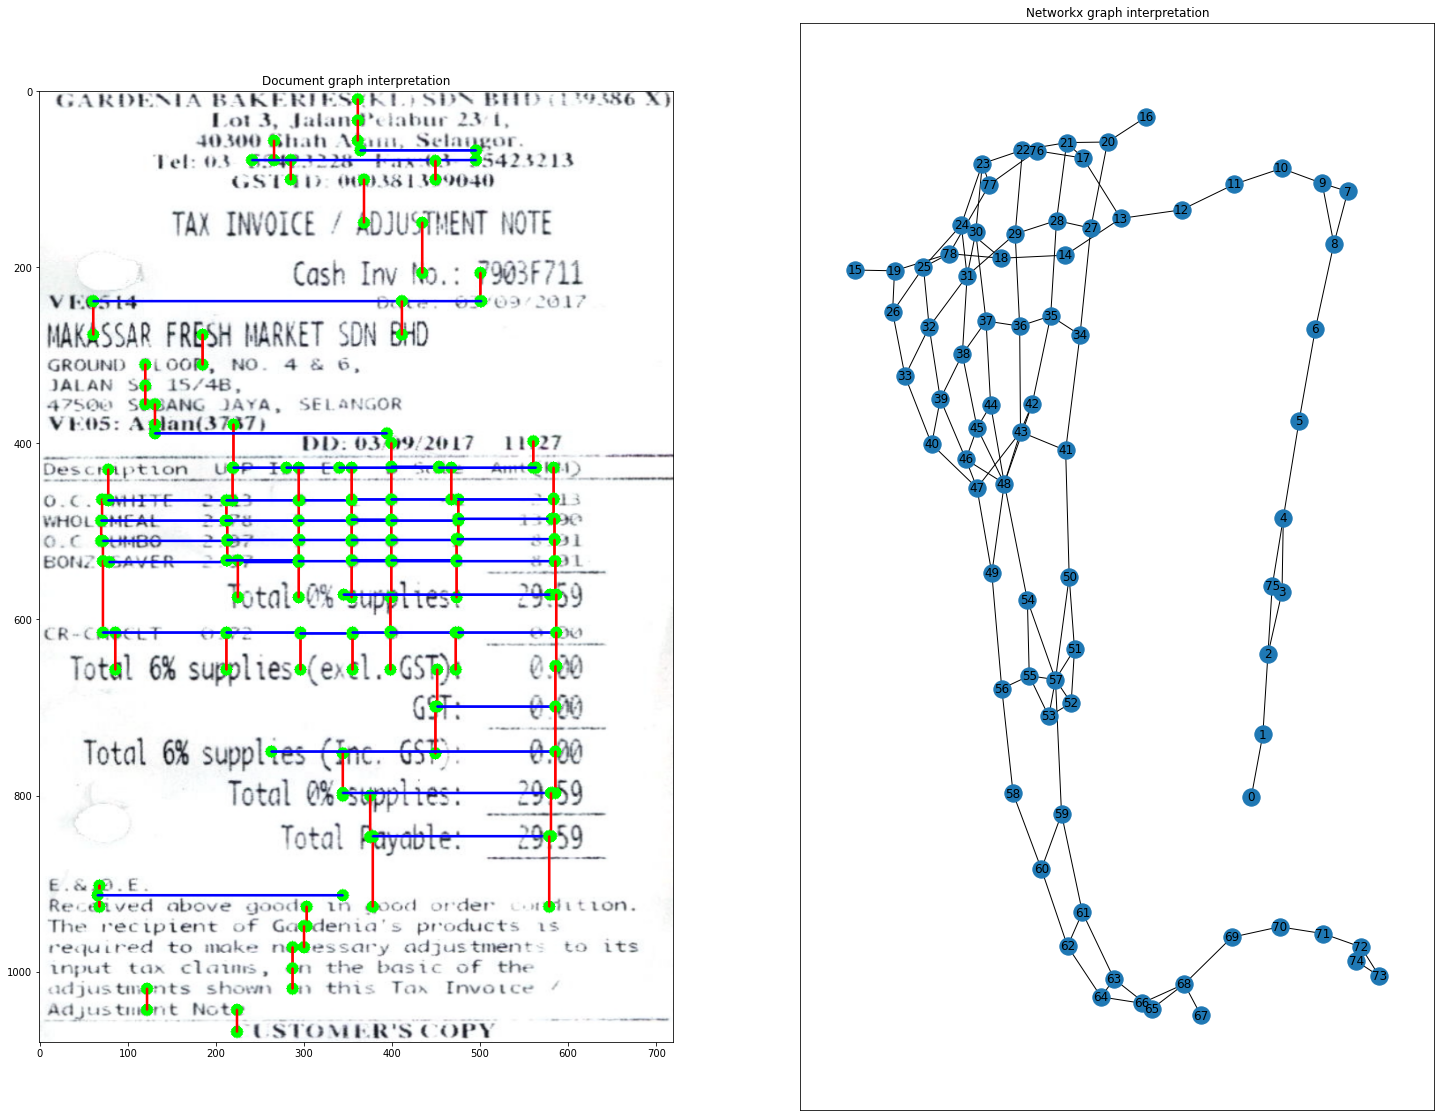

In [18]:
def plot_document_graph(df, g, resize=(conf.RESIZE_WIDTH, conf.RESIZE_HEIGHT)):
    assert df['image'].nunique() == 1, 'The plot is only for one document. Pass a df corresponding to only image/txt file.'
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25,20))
    file_path, image_file = df['file_path'].unique()[0], df['image'].unique()[0]
    doc_xmin, doc_ymin, doc_xmax, doc_ymax = df['doc_xmin'].unique()[0], df['doc_ymin'].unique()[0], df['doc_xmax'].unique()[0], df['doc_ymax'].unique()[0]
    image = cv2.imread(os.path.join(file_path, image_file))
    image = image[doc_ymin: doc_ymax, doc_xmin: doc_xmax, :]
    image = cv2.resize(image, resize)
    for ind, row in df.iterrows():
        if row['vertically_close_object_ids'] != -1:
            image = cv2.circle(image, (int(row['vertically_close_object_x_src_coord_centroid']), int(row['vertically_close_object_y_src_coord_centroid'])), radius=7, color=(0, 255, 0), thickness=-1)
            image = cv2.circle(image, (int(row['vertically_close_object_x_dst_coord_centroid']), int(row['vertically_close_object_y_dst_coord_centroid'])), radius=7, color=(0, 255, 0), thickness=-1)
            image = cv2.line(image, (int(row['vertically_close_object_x_src_coord_centroid']), int(row['vertically_close_object_y_src_coord_centroid'])), (int(row['vertically_close_object_x_dst_coord_centroid']), int(row['vertically_close_object_y_dst_coord_centroid'])), color=(255, 0, 0), thickness=2)
        if row['horizontally_close_object_ids'] != -1:
            image = cv2.circle(image, (int(row['horizontally_close_object_x_src_coord_centroid']), int(row['horizontally_close_object_y_src_coord_centroid'])), radius=7, color=(0, 255, 0), thickness=-1)
            image = cv2.circle(image, (int(row['horizontally_close_object_x_dst_coord_centroid']), int(row['horizontally_close_object_y_dst_coord_centroid'])), radius=7, color=(0, 255, 0), thickness=-1)
            image = cv2.line(image, (int(row['horizontally_close_object_x_src_coord_centroid']), int(row['horizontally_close_object_y_src_coord_centroid'])), (int(row['horizontally_close_object_x_dst_coord_centroid']), int(row['horizontally_close_object_y_dst_coord_centroid'])), color=(0, 0, 255), thickness=2)
    ax1.imshow(image)
    ax1.set_title('Document graph interpretation')
    ax2.set_title('Networkx graph interpretation')
    nx.draw_networkx(g, ax=ax2)

plot_document_graph(__df__, __graph__)

In [19]:
ce_weights = np.asarray([1 - (i / len(df_dataset)) for i in list(df_dataset['label'].value_counts().sort_index())])
ce_weights

array([0.14279473, 0.95319781, 0.97871039, 0.97734157, 0.9479555 ])

In [20]:
def plot_graph(g, ind):
    figure = plt.figure(figsize=(15, 15))
    plt.title(f'Graph for data point at index {ind}')
    nx.draw_networkx(g)
    
def create_graph_dataset(df):
    graphs, dataset = [], []
    docs = list(df['image'].unique())
    for doc in tqdm(docs):
        _, _, graph, _, _, _, _, _, data = Graph(df[df['image']==doc]).graph()
        if len(data.edge_index.shape) == 2:
            graphs.append(graph)
            dataset.append(data)
    return graphs, dataset

graphs, dataset = create_graph_dataset(df_dataset)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 642/642 [02:07<00:00,  5.02it/s]


Count of valid and cleaned data = 642


Data(x=[52, 51], edge_index=[2, 128], y=[52])

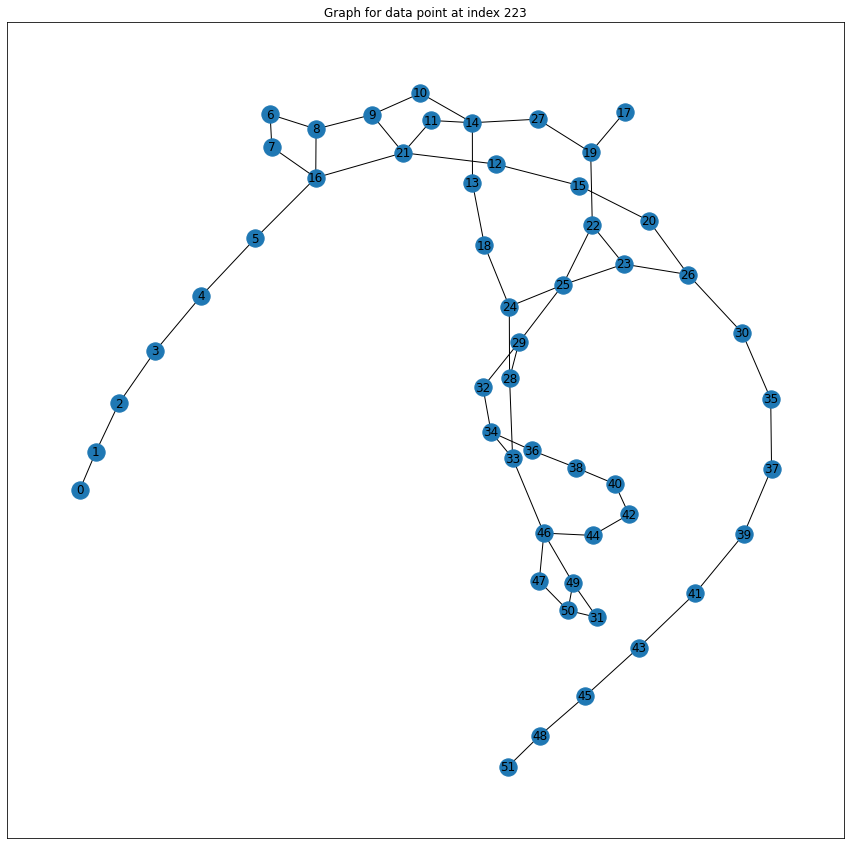

In [21]:
ind = random.choice(np.arange(0, len(graphs)))
plot_graph(graphs[ind], ind)
print('Count of valid and cleaned data =', len(dataset))
dataset[ind]

In [22]:
def get_data_module(dataset, val_split=conf.VAL_SPLIT, test_split=conf.TEST_SPLIT, batch_size=conf.BATCH_SIZE, random_seed=42):
    random.seed(random_seed)
    random.shuffle(dataset)
    dataset_length = len(dataset)
    train_dataset = dataset[: int(dataset_length * (1 - (val_split + test_split)))]
    val_dataset = dataset[int(dataset_length * (1 - (val_split + test_split))): int(dataset_length * (1 - val_split))]
    test_dataset = dataset[int(dataset_length * (1 - val_split)): ]
    return train_dataset, val_dataset, test_dataset, G_LightningDataset(train_dataset, val_dataset, test_dataset, batch_size)

train_dataset, val_dataset, test_dataset, data_module = get_data_module(dataset)

## Model Definition and Training

In [23]:
def visualize_tsne(h, color, n_components=2):
    if isinstance(h, np.ndarray):
        z = TSNE(n_components=n_components).fit_transform(h)
    else:
        z = TSNE(n_components=n_components).fit_transform(h.detach().cpu().numpy())       
    plt.figure(figsize=(10, 10))
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.title('TSNE for GCN output')
    plt.scatter(z[:, 0], z[:, 1], s=75, c=color, cmap='Set1')
    plt.show()

In [24]:
class GCN(torch.nn.Module):
    
    def __init__(self, num_features, num_classes, is_spectral=False, K=3, dropout=0.2, torch_seed=42):
        super().__init__()
        torch.manual_seed(torch_seed)
        self.dropout=dropout
        if is_spectral:
            self.conv1 = ChebConv(num_features, 32, K=K)
            self.conv2 = ChebConv(32, 16, K=K)
            self.conv3 = ChebConv(16, num_classes, K=K)
        else:
            self.conv1 = GCNConv(num_features, 32, improved=True)
            self.conv2 = GCNConv(32, 16, improved=True)
            self.conv3 = GCNConv(16, num_classes, improved=True)

    def forward(self, x, edge_index):
        x = F.dropout(self.conv1(x, edge_index).relu(), p=self.dropout, training=self.training)
        x = F.dropout(self.conv2(x, edge_index).relu(), p=self.dropout, training=self.training)
        x = F.log_softmax(self.conv3(x, edge_index), dim=1)
        return x

GCN(
  (conv1): GCNConv(51, 32)
  (conv2): GCNConv(32, 16)
  (conv3): GCNConv(16, 5)
)
Model output shape =  torch.Size([79, 5])


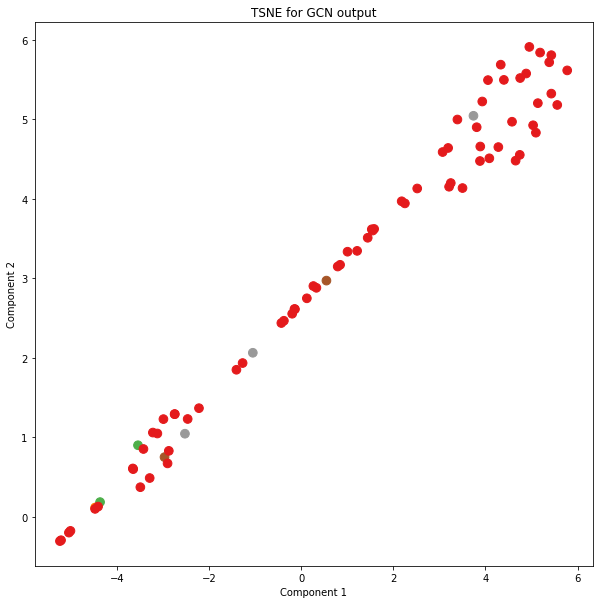

In [25]:
__model__ = GCN(num_features=51, num_classes=len(conf.LABEL))
print(__model__)
__model__.eval()
__out__ = __model__(__data__.x, __data__.edge_index)
print('Model output shape = ', __out__.size())
visualize_tsne(__out__, color=__data__.y)

GCN(
  (conv1): ChebConv(51, 32, K=3, normalization=sym)
  (conv2): ChebConv(32, 16, K=3, normalization=sym)
  (conv3): ChebConv(16, 5, K=3, normalization=sym)
)
Model output shape =  torch.Size([79, 5])


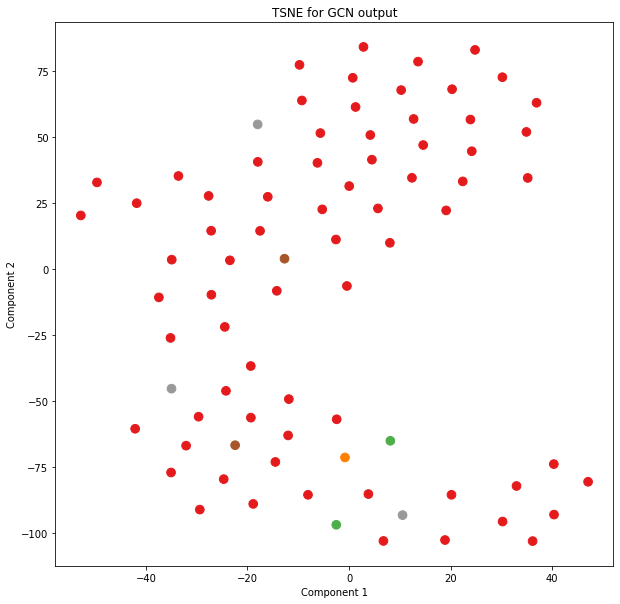

In [26]:
__model__ = GCN(num_features=51, num_classes=len(conf.LABEL), is_spectral=True)
print(__model__)
__model__.eval()
__out__ = __model__(__data__.x, __data__.edge_index)
print('Model output shape = ', __out__.size())
visualize_tsne(__out__, color=__data__.y)

In [27]:
class LitGCN(pl.LightningModule):

    def __init__(self, ce_weights, is_spectral=False, num_features=51, num_classes=5, batch_size=128, learning_rate=1e-3, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01):
        super().__init__()
        self.accuracy = torchmetrics.Accuracy()
        self.ce_weights = ce_weights
        self.criterion = nn.CrossEntropyLoss(weight=torch.from_numpy(ce_weights).float())
        self.model = GCN(num_features=num_features, num_classes=num_classes, is_spectral=is_spectral)
        self.learning_rate=learning_rate
        self.batch_size = batch_size
        self.betas = betas
        self.eps = eps
        self.weight_decay = weight_decay

    def forward(self, x, edge_index):
        return self.model(x, edge_index)

    def training_step(self, train_batch, batch_idx):
        data = train_batch
        y_hat = self.forward(data.x, data.edge_index)   
        loss = self.criterion(y_hat, data.y)
        acc = self.accuracy(y_hat, data.y)
        self.log('train_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log('train_acc', acc, prog_bar=True, on_step=False, on_epoch=True)
        return loss
    
    def on_train_end(self, *args, **kwargs):
        self.logger.experiment.add_graph(LitGCN(ce_weights=self.ce_weights), [torch.randn((69, 51)), torch.randint(0, 69, (2, 100)).type(torch.LongTensor)])
        for name, params in self.named_parameters():
            self.logger.experiment.add_histogram(name, params, self.current_epoch)

    def validation_step(self, val_batch, batch_idx):
        data = val_batch
        y_hat = self.forward(data.x, data.edge_index)   
        loss = self.criterion(y_hat, data.y)
        acc = self.accuracy(y_hat, data.y)
        self.log('val_loss', loss, prog_bar=True, on_epoch=True)
        self.log('val_acc', acc, prog_bar=True, on_step=False, on_epoch=True)
        return loss
    
    def test_step(self, test_batch, batch_idx):
        data = test_batch
        y_hat = self.forward(data.x, data.edge_index)   
        loss = self.criterion(y_hat, data.y)
        acc = self.accuracy(y_hat, data.y)
        self.log('test_loss', loss, prog_bar=True, on_epoch=True)
        self.log('test_acc', acc, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(), 
            lr=self.learning_rate, 
            betas=self.betas, 
            eps=self.eps, 
            weight_decay=self.weight_decay
        )
        cyclic_lr_scheduler = {
            "scheduler": CyclicLR(
                optimizer=optimizer,
                base_lr=self.learning_rate,
                max_lr=1e-6,
                cycle_momentum=False # False with AdamW
            ),
            "interval": "step"
        }
        return [optimizer], [cyclic_lr_scheduler]
    
    def get_progress_bar_dict(self):
        items = super().get_progress_bar_dict()
        items.pop("v_num", None)
        items.pop("loss", None)
        return items

In [28]:
def test_model(ckpt, ce_weights, demo_data, is_spectral=False):
    model = LitGCN.load_from_checkpoint(checkpoint_path=ckpt, ce_weights=ce_weights, is_spectral=is_spectral)
    model.eval()
    out = model(demo_data.x, demo_data.edge_index)
    print('Model output shape = ', out.size())
    visualize_tsne(out, color=demo_data.y)
    df_model_res = {
        'pred_label': [],
        'true_label': []
    }
    for test_data in test_dataset:
        y_hat = model(test_data.x, test_data.edge_index)
        y_hat = y_hat.cpu().detach().numpy()
        y_hat = np.argmax(y_hat, axis=1)
        y = test_data.y.cpu().detach().numpy()
        for i in range(len(y)):
            df_model_res['pred_label'].append(y_hat[i])
            df_model_res['true_label'].append(y[i])
    df_model_res = pd.DataFrame.from_dict(df_model_res)
    print(classification_report(df_model_res['pred_label'], df_model_res['true_label']))
    return df_model_res

### Spatial GCN

In [30]:
# Set/Create and get an experiment
SPATIAL_EXPERIMENT_NAME = 'Spatial GCN'
mlflow.set_experiment(experiment_name=SPATIAL_EXPERIMENT_NAME)
spatial_experiment = mlflow.get_experiment_by_name(SPATIAL_EXPERIMENT_NAME)
print("Experiment_id: {}".format(spatial_experiment.experiment_id))
print("Artifact Location: {}".format(spatial_experiment.artifact_location))
print("Tags: {}".format(spatial_experiment.tags))
print("Lifecycle_stage: {}".format(spatial_experiment.lifecycle_stage))

2022/02/05 23:39:48 INFO mlflow.tracking.fluent: Experiment with name 'Spatial GCN' does not exist. Creating a new experiment.


Experiment_id: 2
Artifact Location: gs://som-tmp/tmp/mlflow-local/2
Tags: {}
Lifecycle_stage: active


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/tyche/miniconda3/envs/ocr/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:143: LightningDeprecationWarning: The `LightningModule.get_progress_bar_dict` method was deprecated in v1.5 and will be removed in v1.7. Please use the `ProgressBarBase.get_metrics` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Finding best initial lr: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 63.44it/s]


CPU times: user 6.82 s, sys: 542 ms, total: 7.36 s
Wall time: 3.95 s


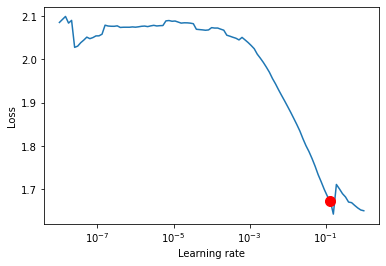

In [31]:
%%time
model_spatial = LitGCN(ce_weights=ce_weights)
trainer_spatial = pl.Trainer(auto_lr_find=True, gpus=1 if torch.cuda.is_available() else None, default_root_dir=conf.MODEL_SAVED_PATH+'/temp')
lr_finder_spatial = trainer_spatial.tuner.lr_find(model_spatial, data_module)
fig = lr_finder_spatial.plot(suggest=True)
fig.show()

In [32]:
%%time
# mlflow.pytorch.autolog()
trainer_spatial = pl.Trainer(default_root_dir=conf.MODEL_SAVED_PATH,
                             precision=32,
                             limit_train_batches=0.5,
                             gpus=1 if torch.cuda.is_available() else None, 
                             max_epochs=conf.EPOCHS,
                             logger=TensorBoardLogger(conf.MODEL_SAVED_PATH, name='spatial_gcn'),
                             callbacks=[
                                    LearningRateMonitor(logging_interval="step"), 
                                    ModelCheckpoint(monitor="train_loss"),
                                ],
                             # resume_from_checkpoint=conf.MODEL_SAVED_PATH + '/' +'spatial_gcn' +'/version_0/checkpoints/epoch=98-step=6137.ckpt'
                             )

# with mlflow.start_run(run_name=SPATIAL_EXPERIMENT_NAME + ' ' + datetime.now().strftime('%d-%m-%Y %H:%M'), tags={'time': datetime.now().strftime('%d-%m-%Y %H:%M')}) as run:
trainer_spatial.fit(LitGCN(ce_weights=ce_weights), data_module)
trainer_spatial.test(ckpt_path="best", datamodule=data_module)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/tyche/miniconda3/envs/ocr/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | accuracy  | Accuracy         | 0     
1 | criterion | CrossEntropyLoss | 0     
2 | model     | GCN              | 2.3 K 
-----------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)


Epoch 0:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 2/3 [00:00<00:00, 42.53it/s]
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                                                                                                                                                                   | 0/1 [00:00<?, ?it/s]

2022-02-05 23:40:00.074815: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/tyche/miniconda3/envs/ocr/lib/python3.8/site-packages/cv2/../../lib64:
2022-02-05 23:40:00.074842: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Epoch 1:  67%|███████████████████████████████████████████████████████████████████████▎                                   | 2/3 [00:00<00:00, 47.50it/s, val_loss=1.820, val_acc=0.049, train_loss=2.060, train_acc=0.0374]
Validating: 0it [00:00, ?it/s]
Epoch 2:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 53.47it/s, val_loss=1.710, val_acc=0.0552, train_loss=1.900, train_acc=0.0463]
Validating: 0it [00:00, ?it/s]
Epoch 3:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 49.57it/s, val_loss=1.630, val_acc=0.0635, train_loss=1.820, train_acc=0.0484]
Validating: 0it [00:00, ?it/s]
Epoch 4:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 53.98it/s, val_loss=1.570, val_acc=0.0759, train_loss=1.720, train_acc=0.0625]
Validating: 0it [00:00, ?it/s]


Epoch 18:  67%|███████████████████████████████████████████████████████████████████████▎                                   | 2/3 [00:00<00:00, 51.57it/s, val_loss=1.280, val_acc=0.861, train_loss=1.350, train_acc=0.816]
Validating: 0it [00:00, ?it/s]
Epoch 19:  67%|███████████████████████████████████████████████████████████████████████▎                                   | 2/3 [00:00<00:00, 51.70it/s, val_loss=1.270, val_acc=0.866, train_loss=1.350, train_acc=0.814]
Validating: 0it [00:00, ?it/s]
Epoch 20:  67%|███████████████████████████████████████████████████████████████████████▎                                   | 2/3 [00:00<00:00, 28.34it/s, val_loss=1.260, val_acc=0.866, train_loss=1.330, train_acc=0.823]
Validating: 0it [00:00, ?it/s]
Epoch 21:  67%|███████████████████████████████████████████████████████████████████████▎                                   | 2/3 [00:00<00:00, 46.49it/s, val_loss=1.240, val_acc=0.865, train_loss=1.330, train_acc=0.822]
Validating: 0it [00:00, ?it/s]


Epoch 35:  67%|███████████████████████████████████████████████████████████████████████▎                                   | 2/3 [00:00<00:00, 36.84it/s, val_loss=1.040, val_acc=0.860, train_loss=1.140, train_acc=0.811]
Validating: 0it [00:00, ?it/s]
Epoch 36:  67%|███████████████████████████████████████████████████████████████████████▎                                   | 2/3 [00:00<00:00, 47.39it/s, val_loss=1.030, val_acc=0.859, train_loss=1.120, train_acc=0.818]
Validating: 0it [00:00, ?it/s]
Epoch 37:  67%|███████████████████████████████████████████████████████████████████████▎                                   | 2/3 [00:00<00:00, 38.56it/s, val_loss=1.020, val_acc=0.859, train_loss=1.120, train_acc=0.814]
Validating: 0it [00:00, ?it/s]
Epoch 38:  67%|███████████████████████████████████████████████████████████████████████▎                                   | 2/3 [00:00<00:00, 35.58it/s, val_loss=1.010, val_acc=0.859, train_loss=1.110, train_acc=0.813]
Validating: 0it [00:00, ?it/s]


Epoch 52:  67%|███████████████████████████████████████████████████████████████████████▎                                   | 2/3 [00:00<00:00, 32.81it/s, val_loss=0.889, val_acc=0.856, train_loss=0.987, train_acc=0.798]
Validating: 0it [00:00, ?it/s]
Epoch 53:  67%|███████████████████████████████████████████████████████████████████████▎                                   | 2/3 [00:00<00:00, 46.70it/s, val_loss=0.880, val_acc=0.855, train_loss=0.970, train_acc=0.794]
Validating: 0it [00:00, ?it/s]
Epoch 54:  67%|███████████████████████████████████████████████████████████████████████▎                                   | 2/3 [00:00<00:00, 44.02it/s, val_loss=0.872, val_acc=0.858, train_loss=0.965, train_acc=0.793]
Validating: 0it [00:00, ?it/s]
Epoch 55:  67%|███████████████████████████████████████████████████████████████████████▎                                   | 2/3 [00:00<00:00, 25.90it/s, val_loss=0.863, val_acc=0.858, train_loss=0.966, train_acc=0.797]
Validating: 0it [00:00, ?it/s]


Epoch 69:  67%|███████████████████████████████████████████████████████████████████████▎                                   | 2/3 [00:00<00:00, 47.13it/s, val_loss=0.788, val_acc=0.821, train_loss=0.857, train_acc=0.764]
Validating: 0it [00:00, ?it/s]
Epoch 70:  67%|███████████████████████████████████████████████████████████████████████▎                                   | 2/3 [00:00<00:00, 37.92it/s, val_loss=0.784, val_acc=0.813, train_loss=0.861, train_acc=0.764]
Validating: 0it [00:00, ?it/s]
Epoch 71:  67%|███████████████████████████████████████████████████████████████████████▎                                   | 2/3 [00:00<00:00, 39.93it/s, val_loss=0.780, val_acc=0.805, train_loss=0.885, train_acc=0.754]
Validating: 0it [00:00, ?it/s]
Epoch 72:  67%|███████████████████████████████████████████████████████████████████████▎                                   | 2/3 [00:00<00:00, 49.23it/s, val_loss=0.776, val_acc=0.793, train_loss=0.875, train_acc=0.741]
Validating: 0it [00:00, ?it/s]


Epoch 86:  67%|███████████████████████████████████████████████████████████████████████▎                                   | 2/3 [00:00<00:00, 50.23it/s, val_loss=0.730, val_acc=0.777, train_loss=0.800, train_acc=0.735]
Validating: 0it [00:00, ?it/s]
Epoch 87:  67%|███████████████████████████████████████████████████████████████████████▎                                   | 2/3 [00:00<00:00, 45.13it/s, val_loss=0.727, val_acc=0.781, train_loss=0.807, train_acc=0.736]
Validating: 0it [00:00, ?it/s]
Epoch 88:  67%|███████████████████████████████████████████████████████████████████████▎                                   | 2/3 [00:00<00:00, 38.57it/s, val_loss=0.725, val_acc=0.781, train_loss=0.821, train_acc=0.741]
Validating: 0it [00:00, ?it/s]
Epoch 89:  67%|███████████████████████████████████████████████████████████████████████▎                                   | 2/3 [00:00<00:00, 38.88it/s, val_loss=0.722, val_acc=0.781, train_loss=0.806, train_acc=0.743]
Validating: 0it [00:00, ?it/s]


Epoch 103:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 48.19it/s, val_loss=0.691, val_acc=0.759, train_loss=0.770, train_acc=0.725]
Validating: 0it [00:00, ?it/s]
Epoch 104:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 40.25it/s, val_loss=0.689, val_acc=0.760, train_loss=0.778, train_acc=0.729]
Validating: 0it [00:00, ?it/s]
Epoch 105:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 28.73it/s, val_loss=0.688, val_acc=0.760, train_loss=0.778, train_acc=0.725]
Validating: 0it [00:00, ?it/s]
Epoch 106:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 41.54it/s, val_loss=0.685, val_acc=0.770, train_loss=0.762, train_acc=0.725]
Validating: 0it [00:00, ?it/s]


Epoch 120:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 43.48it/s, val_loss=0.654, val_acc=0.775, train_loss=0.742, train_acc=0.740]
Validating: 0it [00:00, ?it/s]
Epoch 121:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 42.91it/s, val_loss=0.652, val_acc=0.782, train_loss=0.722, train_acc=0.743]
Validating: 0it [00:00, ?it/s]
Epoch 122:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 43.72it/s, val_loss=0.651, val_acc=0.782, train_loss=0.760, train_acc=0.744]
Validating: 0it [00:00, ?it/s]
Epoch 123:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 50.73it/s, val_loss=0.649, val_acc=0.779, train_loss=0.734, train_acc=0.755]
Validating: 0it [00:00, ?it/s]


Epoch 137:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 51.47it/s, val_loss=0.627, val_acc=0.788, train_loss=0.664, train_acc=0.757]
Validating: 0it [00:00, ?it/s]
Epoch 138:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 43.44it/s, val_loss=0.626, val_acc=0.788, train_loss=0.700, train_acc=0.760]
Validating: 0it [00:00, ?it/s]
Epoch 139:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 42.32it/s, val_loss=0.625, val_acc=0.788, train_loss=0.701, train_acc=0.760]
Validating: 0it [00:00, ?it/s]
Epoch 140:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 51.43it/s, val_loss=0.622, val_acc=0.785, train_loss=0.723, train_acc=0.751]
Validating: 0it [00:00, ?it/s]


Epoch 154:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 50.05it/s, val_loss=0.606, val_acc=0.785, train_loss=0.693, train_acc=0.761]
Validating: 0it [00:00, ?it/s]
Epoch 155:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 49.91it/s, val_loss=0.604, val_acc=0.782, train_loss=0.665, train_acc=0.760]
Validating: 0it [00:00, ?it/s]
Epoch 156:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 54.03it/s, val_loss=0.603, val_acc=0.782, train_loss=0.651, train_acc=0.759]
Validating: 0it [00:00, ?it/s]
Epoch 157:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 52.31it/s, val_loss=0.603, val_acc=0.782, train_loss=0.695, train_acc=0.756]
Validating: 0it [00:00, ?it/s]


Epoch 171:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 47.59it/s, val_loss=0.593, val_acc=0.797, train_loss=0.652, train_acc=0.772]
Validating: 0it [00:00, ?it/s]
Epoch 172:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 47.74it/s, val_loss=0.592, val_acc=0.793, train_loss=0.665, train_acc=0.772]
Validating: 0it [00:00, ?it/s]
Epoch 173:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 51.12it/s, val_loss=0.590, val_acc=0.787, train_loss=0.656, train_acc=0.771]
Validating: 0it [00:00, ?it/s]
Epoch 174:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 46.30it/s, val_loss=0.589, val_acc=0.776, train_loss=0.681, train_acc=0.763]
Validating: 0it [00:00, ?it/s]


Epoch 188:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 51.55it/s, val_loss=0.583, val_acc=0.793, train_loss=0.650, train_acc=0.773]
Validating: 0it [00:00, ?it/s]
Epoch 189:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 48.27it/s, val_loss=0.582, val_acc=0.794, train_loss=0.640, train_acc=0.772]
Validating: 0it [00:00, ?it/s]
Epoch 190:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 50.66it/s, val_loss=0.580, val_acc=0.793, train_loss=0.641, train_acc=0.770]
Validating: 0it [00:00, ?it/s]
Epoch 191:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 50.47it/s, val_loss=0.579, val_acc=0.793, train_loss=0.632, train_acc=0.775]
Validating: 0it [00:00, ?it/s]


Epoch 205:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 54.80it/s, val_loss=0.572, val_acc=0.785, train_loss=0.622, train_acc=0.765]
Validating: 0it [00:00, ?it/s]
Epoch 206:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 53.80it/s, val_loss=0.571, val_acc=0.783, train_loss=0.621, train_acc=0.771]
Validating: 0it [00:00, ?it/s]
Epoch 207:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 48.50it/s, val_loss=0.571, val_acc=0.782, train_loss=0.602, train_acc=0.765]
Validating: 0it [00:00, ?it/s]
Epoch 208:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 48.48it/s, val_loss=0.570, val_acc=0.787, train_loss=0.644, train_acc=0.763]
Validating: 0it [00:00, ?it/s]


Epoch 222:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 48.17it/s, val_loss=0.564, val_acc=0.782, train_loss=0.625, train_acc=0.764]
Validating: 0it [00:00, ?it/s]
Epoch 223:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 47.11it/s, val_loss=0.563, val_acc=0.785, train_loss=0.624, train_acc=0.767]
Validating: 0it [00:00, ?it/s]
Epoch 224:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 48.39it/s, val_loss=0.563, val_acc=0.789, train_loss=0.634, train_acc=0.768]
Validating: 0it [00:00, ?it/s]
Epoch 225:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 49.76it/s, val_loss=0.563, val_acc=0.789, train_loss=0.621, train_acc=0.770]
Validating: 0it [00:00, ?it/s]


Epoch 239:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 42.79it/s, val_loss=0.559, val_acc=0.785, train_loss=0.616, train_acc=0.766]
Validating: 0it [00:00, ?it/s]
Epoch 240:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 45.14it/s, val_loss=0.558, val_acc=0.784, train_loss=0.620, train_acc=0.771]
Validating: 0it [00:00, ?it/s]
Epoch 241:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 48.39it/s, val_loss=0.558, val_acc=0.783, train_loss=0.615, train_acc=0.764]
Validating: 0it [00:00, ?it/s]
Epoch 242:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 56.15it/s, val_loss=0.558, val_acc=0.785, train_loss=0.618, train_acc=0.769]
Validating: 0it [00:00, ?it/s]


Epoch 256:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 52.02it/s, val_loss=0.553, val_acc=0.791, train_loss=0.596, train_acc=0.771]
Validating: 0it [00:00, ?it/s]
Epoch 257:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 48.58it/s, val_loss=0.553, val_acc=0.788, train_loss=0.603, train_acc=0.781]
Validating: 0it [00:00, ?it/s]
Epoch 258:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 50.89it/s, val_loss=0.552, val_acc=0.786, train_loss=0.590, train_acc=0.774]
Validating: 0it [00:00, ?it/s]
Epoch 259:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 50.59it/s, val_loss=0.552, val_acc=0.787, train_loss=0.587, train_acc=0.766]
Validating: 0it [00:00, ?it/s]


Epoch 273:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 30.56it/s, val_loss=0.546, val_acc=0.786, train_loss=0.587, train_acc=0.783]
Validating: 0it [00:00, ?it/s]
Epoch 274:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 22.13it/s, val_loss=0.545, val_acc=0.783, train_loss=0.588, train_acc=0.770]
Validating: 0it [00:00, ?it/s]
Epoch 275:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 37.01it/s, val_loss=0.545, val_acc=0.784, train_loss=0.612, train_acc=0.770]
Validating: 0it [00:00, ?it/s]
Epoch 276:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 34.98it/s, val_loss=0.545, val_acc=0.784, train_loss=0.608, train_acc=0.770]
Validating: 0it [00:00, ?it/s]


Epoch 290:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 49.59it/s, val_loss=0.542, val_acc=0.780, train_loss=0.610, train_acc=0.768]
Validating: 0it [00:00, ?it/s]
Epoch 291:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 49.05it/s, val_loss=0.543, val_acc=0.780, train_loss=0.614, train_acc=0.763]
Validating: 0it [00:00, ?it/s]
Epoch 292:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 55.35it/s, val_loss=0.542, val_acc=0.783, train_loss=0.589, train_acc=0.773]
Validating: 0it [00:00, ?it/s]
Epoch 293:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 36.69it/s, val_loss=0.542, val_acc=0.789, train_loss=0.581, train_acc=0.765]
Validating: 0it [00:00, ?it/s]


Epoch 307:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 38.63it/s, val_loss=0.538, val_acc=0.790, train_loss=0.571, train_acc=0.774]
Validating: 0it [00:00, ?it/s]
Epoch 308:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 48.19it/s, val_loss=0.537, val_acc=0.790, train_loss=0.591, train_acc=0.775]
Validating: 0it [00:00, ?it/s]
Epoch 309:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 45.56it/s, val_loss=0.537, val_acc=0.789, train_loss=0.576, train_acc=0.781]
Validating: 0it [00:00, ?it/s]
Epoch 310:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 38.05it/s, val_loss=0.536, val_acc=0.792, train_loss=0.592, train_acc=0.774]
Validating: 0it [00:00, ?it/s]


Epoch 324:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 51.21it/s, val_loss=0.533, val_acc=0.786, train_loss=0.571, train_acc=0.781]
Validating: 0it [00:00, ?it/s]
Epoch 325:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 48.99it/s, val_loss=0.532, val_acc=0.786, train_loss=0.593, train_acc=0.776]
Validating: 0it [00:00, ?it/s]
Epoch 326:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 51.15it/s, val_loss=0.532, val_acc=0.783, train_loss=0.585, train_acc=0.782]
Validating: 0it [00:00, ?it/s]
Epoch 327:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 40.51it/s, val_loss=0.532, val_acc=0.785, train_loss=0.579, train_acc=0.774]
Validating: 0it [00:00, ?it/s]


Epoch 341:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 48.36it/s, val_loss=0.529, val_acc=0.793, train_loss=0.560, train_acc=0.785]
Validating: 0it [00:00, ?it/s]
Epoch 342:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 45.75it/s, val_loss=0.528, val_acc=0.790, train_loss=0.570, train_acc=0.776]
Validating: 0it [00:00, ?it/s]
Epoch 343:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 44.06it/s, val_loss=0.528, val_acc=0.787, train_loss=0.553, train_acc=0.775]
Validating: 0it [00:00, ?it/s]
Epoch 344:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 38.16it/s, val_loss=0.528, val_acc=0.788, train_loss=0.557, train_acc=0.777]
Validating: 0it [00:00, ?it/s]


Epoch 358:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 51.78it/s, val_loss=0.525, val_acc=0.798, train_loss=0.546, train_acc=0.779]
Validating: 0it [00:00, ?it/s]
Epoch 359:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 36.75it/s, val_loss=0.525, val_acc=0.799, train_loss=0.587, train_acc=0.783]
Validating: 0it [00:00, ?it/s]
Epoch 360:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 26.53it/s, val_loss=0.525, val_acc=0.797, train_loss=0.547, train_acc=0.788]
Validating: 0it [00:00, ?it/s]
Epoch 361:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 39.57it/s, val_loss=0.524, val_acc=0.798, train_loss=0.556, train_acc=0.777]
Validating: 0it [00:00, ?it/s]


Epoch 375:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 52.12it/s, val_loss=0.521, val_acc=0.792, train_loss=0.581, train_acc=0.778]
Validating: 0it [00:00, ?it/s]
Epoch 376:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 51.03it/s, val_loss=0.521, val_acc=0.792, train_loss=0.564, train_acc=0.785]
Validating: 0it [00:00, ?it/s]
Epoch 377:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 49.76it/s, val_loss=0.520, val_acc=0.793, train_loss=0.561, train_acc=0.788]
Validating: 0it [00:00, ?it/s]
Epoch 378:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 46.28it/s, val_loss=0.520, val_acc=0.793, train_loss=0.558, train_acc=0.781]
Validating: 0it [00:00, ?it/s]


Epoch 392:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 45.80it/s, val_loss=0.518, val_acc=0.797, train_loss=0.537, train_acc=0.790]
Validating: 0it [00:00, ?it/s]
Epoch 393:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 46.10it/s, val_loss=0.518, val_acc=0.795, train_loss=0.578, train_acc=0.781]
Validating: 0it [00:00, ?it/s]
Epoch 394:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 38.72it/s, val_loss=0.518, val_acc=0.796, train_loss=0.543, train_acc=0.782]
Validating: 0it [00:00, ?it/s]
Epoch 395:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 48.06it/s, val_loss=0.518, val_acc=0.796, train_loss=0.571, train_acc=0.783]
Validating: 0it [00:00, ?it/s]


Epoch 409:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 45.85it/s, val_loss=0.514, val_acc=0.796, train_loss=0.563, train_acc=0.784]
Validating: 0it [00:00, ?it/s]
Epoch 410:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 52.60it/s, val_loss=0.514, val_acc=0.793, train_loss=0.553, train_acc=0.780]
Validating: 0it [00:00, ?it/s]
Epoch 411:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 57.61it/s, val_loss=0.514, val_acc=0.788, train_loss=0.548, train_acc=0.778]
Validating: 0it [00:00, ?it/s]
Epoch 412:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 55.06it/s, val_loss=0.514, val_acc=0.787, train_loss=0.552, train_acc=0.779]
Validating: 0it [00:00, ?it/s]


Epoch 426:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 46.44it/s, val_loss=0.512, val_acc=0.803, train_loss=0.536, train_acc=0.794]
Validating: 0it [00:00, ?it/s]
Epoch 427:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 45.35it/s, val_loss=0.512, val_acc=0.801, train_loss=0.548, train_acc=0.790]
Validating: 0it [00:00, ?it/s]
Epoch 428:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 45.52it/s, val_loss=0.511, val_acc=0.797, train_loss=0.551, train_acc=0.786]
Validating: 0it [00:00, ?it/s]
Epoch 429:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 49.21it/s, val_loss=0.511, val_acc=0.795, train_loss=0.527, train_acc=0.787]
Validating: 0it [00:00, ?it/s]


Epoch 443:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 53.06it/s, val_loss=0.509, val_acc=0.796, train_loss=0.542, train_acc=0.783]
Validating: 0it [00:00, ?it/s]
Epoch 444:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 50.36it/s, val_loss=0.509, val_acc=0.796, train_loss=0.551, train_acc=0.779]
Validating: 0it [00:00, ?it/s]
Epoch 445:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 47.72it/s, val_loss=0.509, val_acc=0.797, train_loss=0.553, train_acc=0.791]
Validating: 0it [00:00, ?it/s]
Epoch 446:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 49.67it/s, val_loss=0.508, val_acc=0.799, train_loss=0.538, train_acc=0.781]
Validating: 0it [00:00, ?it/s]


Epoch 460:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 45.84it/s, val_loss=0.506, val_acc=0.796, train_loss=0.516, train_acc=0.787]
Validating: 0it [00:00, ?it/s]
Epoch 461:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 48.49it/s, val_loss=0.506, val_acc=0.795, train_loss=0.562, train_acc=0.781]
Validating: 0it [00:00, ?it/s]
Epoch 462:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 51.83it/s, val_loss=0.506, val_acc=0.796, train_loss=0.548, train_acc=0.781]
Validating: 0it [00:00, ?it/s]
Epoch 463:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 51.24it/s, val_loss=0.506, val_acc=0.797, train_loss=0.536, train_acc=0.779]
Validating: 0it [00:00, ?it/s]


Epoch 477:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 56.22it/s, val_loss=0.504, val_acc=0.801, train_loss=0.534, train_acc=0.785]
Validating: 0it [00:00, ?it/s]
Epoch 478:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 49.15it/s, val_loss=0.504, val_acc=0.796, train_loss=0.547, train_acc=0.786]
Validating: 0it [00:00, ?it/s]
Epoch 479:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 42.51it/s, val_loss=0.504, val_acc=0.795, train_loss=0.549, train_acc=0.787]
Validating: 0it [00:00, ?it/s]
Epoch 480:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 49.40it/s, val_loss=0.504, val_acc=0.793, train_loss=0.542, train_acc=0.782]
Validating: 0it [00:00, ?it/s]


Epoch 494:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 45.23it/s, val_loss=0.502, val_acc=0.801, train_loss=0.572, train_acc=0.780]
Validating: 0it [00:00, ?it/s]
Epoch 495:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 54.55it/s, val_loss=0.502, val_acc=0.805, train_loss=0.537, train_acc=0.783]
Validating: 0it [00:00, ?it/s]
Epoch 496:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 48.92it/s, val_loss=0.502, val_acc=0.805, train_loss=0.554, train_acc=0.784]
Validating: 0it [00:00, ?it/s]
Epoch 497:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 49.36it/s, val_loss=0.502, val_acc=0.806, train_loss=0.532, train_acc=0.790]
Validating: 0it [00:00, ?it/s]


/home/tyche/miniconda3/envs/ocr/lib/python3.8/site-packages/torch/_jit_internal.py:668: LightningDeprecationWarning: The `LightningModule.loaded_optimizer_states_dict` property is deprecated in v1.4 and will be removed in v1.6.
  if hasattr(mod, name):
/home/tyche/miniconda3/envs/ocr/lib/python3.8/site-packages/torch/_jit_internal.py:668: LightningDeprecationWarning: The `LightningModule.model_size` property was deprecated in v1.5 and will be removed in v1.7. Please use the `pytorch_lightning.utilities.memory.get_model_size_mb`.
  if hasattr(mod, name):
/home/tyche/miniconda3/envs/ocr/lib/python3.8/site-packages/torch/_jit_internal.py:669: LightningDeprecationWarning: The `LightningModule.model_size` property was deprecated in v1.5 and will be removed in v1.7. Please use the `pytorch_lightning.utilities.memory.get_model_size_mb`.
  item = getattr(mod, name)
/home/tyche/miniconda3/envs/ocr/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning:

Testing: 0it [00:00, ?it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.7997186779975891, 'test_loss': 0.451905757188797}
--------------------------------------------------------------------------------
Testing: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 54.55it/s]
CPU times: user 1min 48s, sys: 1.77 s, total: 1min 50s
Wall time: 39.6 s


[{'test_loss': 0.451905757188797, 'test_acc': 0.7997186779975891}]

Best path -  ../../../runs/models/spatial_gcn/version_1/checkpoints/epoch=459-step=919.ckpt
Model output shape =  torch.Size([79, 5])


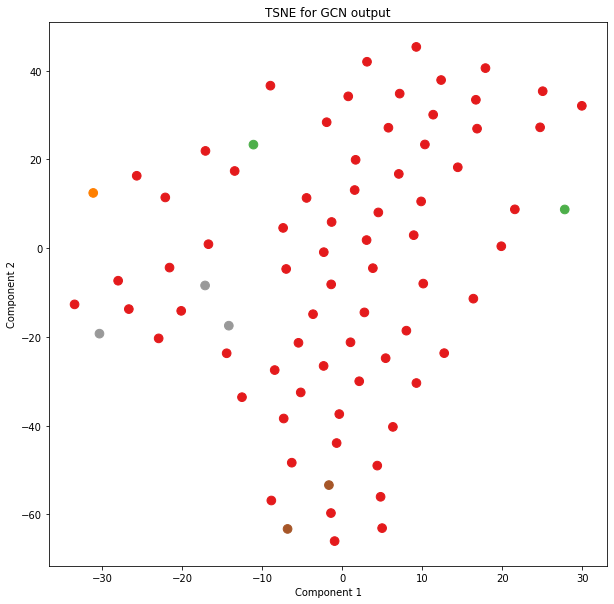

              precision    recall  f1-score   support

           0       0.80      0.98      0.88      2495
           1       0.91      0.53      0.67       272
           2       0.77      0.52      0.62       110
           3       0.90      0.39      0.55       188
           4       0.74      0.27      0.40       490

    accuracy                           0.80      3555
   macro avg       0.82      0.54      0.62      3555
weighted avg       0.80      0.80      0.77      3555



In [33]:
print('Best path - ', trainer_spatial.checkpoint_callbacks[0].best_model_path)
res_spatial = test_model(trainer_spatial.checkpoint_callbacks[0].best_model_path, ce_weights, __data__)

In [34]:
print(classification_report(res_spatial[res_spatial['true_label'] != 0]['pred_label'], res_spatial[res_spatial['true_label'] != 0]['true_label']))
res_spatial[res_spatial['true_label'] != 0]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        60
           1       0.91      0.91      0.91       158
           2       0.77      0.84      0.80        68
           3       0.90      1.00      0.95        74
           4       0.74      1.00      0.85       134

    accuracy                           0.83       494
   macro avg       0.66      0.75      0.70       494
weighted avg       0.73      0.83      0.77       494



,pred_label,true_label
0,2,2
2,1,1
3,1,1
4,1,1
11,3,3
...,...,...
3541,4,4
3543,4,4
3545,4,4
3547,0,4


In [35]:
res_spatial[(res_spatial['true_label'] != res_spatial['pred_label']) & (res_spatial['true_label'] != 0)]

,pred_label,true_label
162,0,4
252,1,2
327,0,4
450,0,1
468,0,4
...,...,...
3494,0,1
3505,0,4
3516,1,2
3547,0,4


<AxesSubplot:ylabel='Density'>

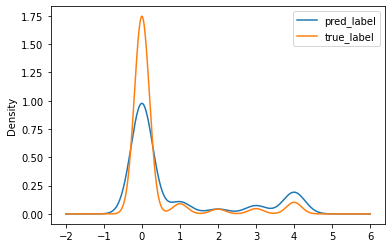

In [36]:
res_spatial.plot.kde()

### Spectral GCN

In [37]:
# Set/Create and get an experiment
SPECTRAL_EXPERIMENT_NAME = 'Spectral GCN'
mlflow.set_experiment(experiment_name=SPECTRAL_EXPERIMENT_NAME)
spectral_experiment = mlflow.get_experiment_by_name(SPECTRAL_EXPERIMENT_NAME)
print("Experiment_id: {}".format(spectral_experiment.experiment_id))
print("Artifact Location: {}".format(spectral_experiment.artifact_location))
print("Tags: {}".format(spectral_experiment.tags))
print("Lifecycle_stage: {}".format(spectral_experiment.lifecycle_stage))

2022/02/05 23:41:07 INFO mlflow.tracking.fluent: Experiment with name 'Spectral GCN' does not exist. Creating a new experiment.


Experiment_id: 3
Artifact Location: gs://som-tmp/tmp/mlflow-local/3
Tags: {}
Lifecycle_stage: active


/home/tyche/miniconda3/envs/ocr/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:90: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/tyche/miniconda3/envs/ocr/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:143: LightningDeprecationWarning: The `LightningModule.get_progress_bar_dict` method was deprecated in v1.5 and will be removed in v1.7. Please use the `ProgressBarBase.get_metrics` instead.
  rank_zero_deprecation(
/home/tyche/miniconda3/envs/ocr/lib/python3.8/site-packages/p

CPU times: user 5.94 s, sys: 20.3 ms, total: 5.96 s
Wall time: 2.33 s


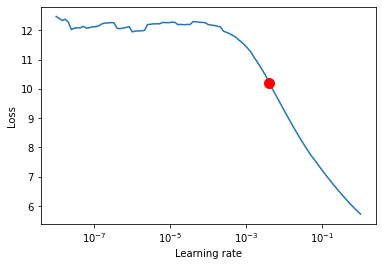

In [38]:
%%time
model_spectral = LitGCN(ce_weights=ce_weights, is_spectral=True)
trainer_spectral = pl.Trainer(auto_lr_find=True, gpus=1 if torch.cuda.is_available() else None, progress_bar_refresh_rate=0, default_root_dir=conf.MODEL_SAVED_PATH+'/temp')
lr_finder_spectral = trainer_spectral.tuner.lr_find(model_spectral, data_module)
fig = lr_finder_spectral.plot(suggest=True)
fig.show()

In [39]:
%%time
mlflow.pytorch.autolog()
trainer_spectral = pl.Trainer(default_root_dir=conf.MODEL_SAVED_PATH,
                             precision=32,
                             limit_train_batches=0.5,
                             gpus=1 if torch.cuda.is_available() else None, 
                             max_epochs=conf.EPOCHS,
                             logger=TensorBoardLogger(conf.MODEL_SAVED_PATH, name='spectral_gcn'),
                             callbacks=[
                                    LearningRateMonitor(logging_interval="step"), 
                                    ModelCheckpoint(monitor="train_loss"),
                                ],
                             # resume_from_checkpoint=conf.MODEL_SAVED_PATH + '/' +'spectral_gcn' +'/version_0/checkpoints/epoch=98-step=6137.ckpt'
                             )
with mlflow.start_run(run_name=SPECTRAL_EXPERIMENT_NAME + ' ' + datetime.now().strftime('%d-%m-%Y %H:%M'), tags={'time': datetime.now().strftime('%d-%m-%Y %H:%M')}) as run:
    trainer_spectral.fit(LitGCN(ce_weights=ce_weights, is_spectral=True), data_module)
    trainer_spectral.test(ckpt_path="best", datamodule=data_module)

2022/02/05 23:41:22 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/tyche/miniconda3/envs/ocr/lib/python3.8/site-packages/pytorch_lightning/core/memory.py:16: LightningDeprecationWarning: `pytorch_lightning.core.memory.get_memory_profile` and `pytorch_lightning.core.memory.get_gpu_memory_map` have been moved to `pytorch_lightning.utilities.memory` since v1.5 and will be removed in v1.7."
2022/02/05 23:41:22 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/tyche/miniconda3/envs/ocr/lib/python3.8/site-packages/pytorch_lightning/core/memory.py:25: LightningDeprecationWarning: `pytorch_lightning.core.memory.LayerSummary` and `pytorch_lightning.core.memory.ModelSummary` have been moved to `pytorch_lightning.utilities.model_summary` since v1.5 and will be removed in v1.7."
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/tyche/miniconda3/envs/ocr/

Epoch 0:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 2/3 [00:00<00:00, 30.47it/s]
Validating: 0it [00:00, ?it/s]
Epoch 1:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 36.68it/s, val_loss=7.640, val_acc=0.0181, train_loss=11.70, train_acc=0.0293]
Validating: 0it [00:00, ?it/s]
Epoch 2:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 26.96it/s, val_loss=5.780, val_acc=0.0436, train_loss=9.480, train_acc=0.0474]
Validating: 0it [00:00, ?it/s]
Epoch 3:  67%|███████████████████████████████████████████████████████████████████████▎                                   | 2/3 [00:00<00:00, 40.16it/s, val_loss=4.400, val_acc=0.120, train_loss=7.810, train_acc=0.0767]
Validating: 0it [00:00, ?it/s]


Epoch 17:  67%|███████████████████████████████████████████████████████████████████████▎                                   | 2/3 [00:00<00:00, 37.32it/s, val_loss=1.420, val_acc=0.645, train_loss=1.910, train_acc=0.494]
Validating: 0it [00:00, ?it/s]
Epoch 18:  67%|███████████████████████████████████████████████████████████████████████▎                                   | 2/3 [00:00<00:00, 35.48it/s, val_loss=1.400, val_acc=0.633, train_loss=1.850, train_acc=0.485]
Validating: 0it [00:00, ?it/s]
Epoch 19:  67%|███████████████████████████████████████████████████████████████████████▎                                   | 2/3 [00:00<00:00, 33.39it/s, val_loss=1.390, val_acc=0.617, train_loss=1.800, train_acc=0.471]
Validating: 0it [00:00, ?it/s]
Epoch 20:  67%|███████████████████████████████████████████████████████████████████████▎                                   | 2/3 [00:00<00:00, 36.47it/s, val_loss=1.370, val_acc=0.608, train_loss=1.730, train_acc=0.470]
Validating: 0it [00:00, ?it/s]


Epoch 34:  67%|███████████████████████████████████████████████████████████████████████▎                                   | 2/3 [00:00<00:00, 38.88it/s, val_loss=1.210, val_acc=0.566, train_loss=1.400, train_acc=0.476]
Validating: 0it [00:00, ?it/s]
Epoch 35:  67%|███████████████████████████████████████████████████████████████████████▎                                   | 2/3 [00:00<00:00, 42.22it/s, val_loss=1.210, val_acc=0.575, train_loss=1.400, train_acc=0.477]
Validating: 0it [00:00, ?it/s]
Epoch 36:  67%|███████████████████████████████████████████████████████████████████████▎                                   | 2/3 [00:00<00:00, 38.22it/s, val_loss=1.200, val_acc=0.592, train_loss=1.380, train_acc=0.491]
Validating: 0it [00:00, ?it/s]
Epoch 37:  67%|███████████████████████████████████████████████████████████████████████▎                                   | 2/3 [00:00<00:00, 41.57it/s, val_loss=1.190, val_acc=0.606, train_loss=1.390, train_acc=0.498]
Validating: 0it [00:00, ?it/s]


Epoch 51:  67%|███████████████████████████████████████████████████████████████████████▎                                   | 2/3 [00:00<00:00, 39.17it/s, val_loss=1.060, val_acc=0.687, train_loss=1.280, train_acc=0.577]
Validating: 0it [00:00, ?it/s]
Epoch 52:  67%|███████████████████████████████████████████████████████████████████████▎                                   | 2/3 [00:00<00:00, 36.79it/s, val_loss=1.060, val_acc=0.690, train_loss=1.240, train_acc=0.580]
Validating: 0it [00:00, ?it/s]
Epoch 53:  67%|███████████████████████████████████████████████████████████████████████▎                                   | 2/3 [00:00<00:00, 31.94it/s, val_loss=1.050, val_acc=0.692, train_loss=1.230, train_acc=0.586]
Validating: 0it [00:00, ?it/s]
Epoch 54:  67%|███████████████████████████████████████████████████████████████████████▎                                   | 2/3 [00:00<00:00, 37.36it/s, val_loss=1.040, val_acc=0.700, train_loss=1.240, train_acc=0.588]
Validating: 0it [00:00, ?it/s]


Epoch 68:  67%|███████████████████████████████████████████████████████████████████████▎                                   | 2/3 [00:00<00:00, 35.94it/s, val_loss=0.955, val_acc=0.732, train_loss=1.150, train_acc=0.637]
Validating: 0it [00:00, ?it/s]
Epoch 69:  67%|███████████████████████████████████████████████████████████████████████▎                                   | 2/3 [00:00<00:00, 37.91it/s, val_loss=0.950, val_acc=0.732, train_loss=1.160, train_acc=0.630]
Validating: 0it [00:00, ?it/s]
Epoch 70:  67%|███████████████████████████████████████████████████████████████████████▎                                   | 2/3 [00:00<00:00, 42.73it/s, val_loss=0.945, val_acc=0.736, train_loss=1.130, train_acc=0.640]
Validating: 0it [00:00, ?it/s]
Epoch 71:  67%|███████████████████████████████████████████████████████████████████████▎                                   | 2/3 [00:00<00:00, 44.74it/s, val_loss=0.940, val_acc=0.737, train_loss=1.130, train_acc=0.640]
Validating: 0it [00:00, ?it/s]


Epoch 85:  67%|███████████████████████████████████████████████████████████████████████▎                                   | 2/3 [00:00<00:00, 39.54it/s, val_loss=0.871, val_acc=0.764, train_loss=1.070, train_acc=0.671]
Validating: 0it [00:00, ?it/s]
Epoch 86:  67%|███████████████████████████████████████████████████████████████████████▎                                   | 2/3 [00:00<00:00, 39.20it/s, val_loss=0.870, val_acc=0.760, train_loss=1.060, train_acc=0.671]
Validating: 0it [00:00, ?it/s]
Epoch 87:  67%|███████████████████████████████████████████████████████████████████████▎                                   | 2/3 [00:00<00:00, 42.08it/s, val_loss=0.869, val_acc=0.759, train_loss=1.040, train_acc=0.664]
Validating: 0it [00:00, ?it/s]
Epoch 88:  67%|███████████████████████████████████████████████████████████████████████▎                                   | 2/3 [00:00<00:00, 44.13it/s, val_loss=0.867, val_acc=0.758, train_loss=1.020, train_acc=0.670]
Validating: 0it [00:00, ?it/s]


Epoch 102:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 40.97it/s, val_loss=0.800, val_acc=0.779, train_loss=0.952, train_acc=0.705]
Validating: 0it [00:00, ?it/s]
Epoch 103:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 38.80it/s, val_loss=0.796, val_acc=0.777, train_loss=0.987, train_acc=0.693]
Validating: 0it [00:00, ?it/s]
Epoch 104:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 42.07it/s, val_loss=0.795, val_acc=0.769, train_loss=0.968, train_acc=0.698]
Validating: 0it [00:00, ?it/s]
Epoch 105:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 38.54it/s, val_loss=0.795, val_acc=0.762, train_loss=0.968, train_acc=0.683]
Validating: 0it [00:00, ?it/s]


Epoch 119:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 39.28it/s, val_loss=0.734, val_acc=0.767, train_loss=0.920, train_acc=0.698]
Validating: 0it [00:00, ?it/s]
Epoch 120:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 39.96it/s, val_loss=0.728, val_acc=0.766, train_loss=0.927, train_acc=0.694]
Validating: 0it [00:00, ?it/s]
Epoch 121:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 41.62it/s, val_loss=0.722, val_acc=0.767, train_loss=0.924, train_acc=0.694]
Validating: 0it [00:00, ?it/s]
Epoch 122:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 40.25it/s, val_loss=0.719, val_acc=0.767, train_loss=0.919, train_acc=0.699]
Validating: 0it [00:00, ?it/s]


Epoch 136:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 43.42it/s, val_loss=0.654, val_acc=0.784, train_loss=0.860, train_acc=0.708]
Validating: 0it [00:00, ?it/s]
Epoch 137:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 40.39it/s, val_loss=0.650, val_acc=0.785, train_loss=0.837, train_acc=0.710]
Validating: 0it [00:00, ?it/s]
Epoch 138:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 37.88it/s, val_loss=0.648, val_acc=0.784, train_loss=0.840, train_acc=0.712]
Validating: 0it [00:00, ?it/s]
Epoch 139:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 38.09it/s, val_loss=0.644, val_acc=0.784, train_loss=0.830, train_acc=0.713]
Validating: 0it [00:00, ?it/s]


Epoch 153:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 38.93it/s, val_loss=0.596, val_acc=0.786, train_loss=0.756, train_acc=0.730]
Validating: 0it [00:00, ?it/s]
Epoch 154:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 41.15it/s, val_loss=0.593, val_acc=0.785, train_loss=0.768, train_acc=0.723]
Validating: 0it [00:00, ?it/s]
Epoch 155:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 43.29it/s, val_loss=0.589, val_acc=0.790, train_loss=0.774, train_acc=0.725]
Validating: 0it [00:00, ?it/s]
Epoch 156:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 36.20it/s, val_loss=0.585, val_acc=0.792, train_loss=0.780, train_acc=0.733]
Validating: 0it [00:00, ?it/s]


Epoch 170:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 41.10it/s, val_loss=0.553, val_acc=0.802, train_loss=0.720, train_acc=0.752]
Validating: 0it [00:00, ?it/s]
Epoch 171:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 41.06it/s, val_loss=0.551, val_acc=0.801, train_loss=0.716, train_acc=0.748]
Validating: 0it [00:00, ?it/s]
Epoch 172:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 37.31it/s, val_loss=0.549, val_acc=0.801, train_loss=0.738, train_acc=0.744]
Validating: 0it [00:00, ?it/s]
Epoch 173:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 38.30it/s, val_loss=0.547, val_acc=0.805, train_loss=0.719, train_acc=0.744]
Validating: 0it [00:00, ?it/s]


Epoch 187:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 42.88it/s, val_loss=0.532, val_acc=0.804, train_loss=0.703, train_acc=0.752]
Validating: 0it [00:00, ?it/s]
Epoch 188:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 39.25it/s, val_loss=0.532, val_acc=0.800, train_loss=0.693, train_acc=0.756]
Validating: 0it [00:00, ?it/s]
Epoch 189:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 47.26it/s, val_loss=0.531, val_acc=0.798, train_loss=0.683, train_acc=0.757]
Validating: 0it [00:00, ?it/s]
Epoch 190:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 45.49it/s, val_loss=0.529, val_acc=0.800, train_loss=0.672, train_acc=0.749]
Validating: 0it [00:00, ?it/s]


Epoch 204:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 35.89it/s, val_loss=0.515, val_acc=0.809, train_loss=0.681, train_acc=0.757]
Validating: 0it [00:00, ?it/s]
Epoch 205:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 35.45it/s, val_loss=0.515, val_acc=0.803, train_loss=0.660, train_acc=0.758]
Validating: 0it [00:00, ?it/s]
Epoch 206:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 41.04it/s, val_loss=0.515, val_acc=0.802, train_loss=0.666, train_acc=0.750]
Validating: 0it [00:00, ?it/s]
Epoch 207:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 37.91it/s, val_loss=0.514, val_acc=0.803, train_loss=0.694, train_acc=0.752]
Validating: 0it [00:00, ?it/s]


Epoch 221:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 42.89it/s, val_loss=0.504, val_acc=0.811, train_loss=0.683, train_acc=0.768]
Validating: 0it [00:00, ?it/s]
Epoch 222:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 32.03it/s, val_loss=0.504, val_acc=0.806, train_loss=0.656, train_acc=0.764]
Validating: 0it [00:00, ?it/s]
Epoch 223:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 30.26it/s, val_loss=0.503, val_acc=0.807, train_loss=0.621, train_acc=0.764]
Validating: 0it [00:00, ?it/s]
Epoch 224:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 32.72it/s, val_loss=0.502, val_acc=0.806, train_loss=0.657, train_acc=0.767]
Validating: 0it [00:00, ?it/s]


Epoch 238:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 32.81it/s, val_loss=0.494, val_acc=0.810, train_loss=0.620, train_acc=0.771]
Validating: 0it [00:00, ?it/s]
Epoch 239:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 39.26it/s, val_loss=0.493, val_acc=0.810, train_loss=0.626, train_acc=0.769]
Validating: 0it [00:00, ?it/s]
Epoch 240:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 32.62it/s, val_loss=0.492, val_acc=0.812, train_loss=0.609, train_acc=0.770]
Validating: 0it [00:00, ?it/s]
Epoch 241:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 29.81it/s, val_loss=0.491, val_acc=0.816, train_loss=0.618, train_acc=0.773]
Validating: 0it [00:00, ?it/s]


Epoch 255:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 33.10it/s, val_loss=0.482, val_acc=0.817, train_loss=0.625, train_acc=0.775]
Validating: 0it [00:00, ?it/s]
Epoch 256:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 30.36it/s, val_loss=0.482, val_acc=0.818, train_loss=0.635, train_acc=0.777]
Validating: 0it [00:00, ?it/s]
Epoch 257:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 31.55it/s, val_loss=0.482, val_acc=0.816, train_loss=0.606, train_acc=0.780]
Validating: 0it [00:00, ?it/s]
Epoch 258:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 39.83it/s, val_loss=0.483, val_acc=0.813, train_loss=0.593, train_acc=0.784]
Validating: 0it [00:00, ?it/s]


Epoch 272:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 44.46it/s, val_loss=0.475, val_acc=0.813, train_loss=0.600, train_acc=0.778]
Validating: 0it [00:00, ?it/s]
Epoch 273:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 40.90it/s, val_loss=0.474, val_acc=0.816, train_loss=0.590, train_acc=0.778]
Validating: 0it [00:00, ?it/s]
Epoch 274:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 40.98it/s, val_loss=0.473, val_acc=0.821, train_loss=0.604, train_acc=0.786]
Validating: 0it [00:00, ?it/s]
Epoch 275:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 44.54it/s, val_loss=0.473, val_acc=0.820, train_loss=0.607, train_acc=0.781]
Validating: 0it [00:00, ?it/s]


Epoch 289:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 36.59it/s, val_loss=0.468, val_acc=0.822, train_loss=0.595, train_acc=0.787]
Validating: 0it [00:00, ?it/s]
Epoch 290:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 35.62it/s, val_loss=0.468, val_acc=0.816, train_loss=0.586, train_acc=0.784]
Validating: 0it [00:00, ?it/s]
Epoch 291:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 36.63it/s, val_loss=0.469, val_acc=0.813, train_loss=0.610, train_acc=0.779]
Validating: 0it [00:00, ?it/s]
Epoch 292:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 35.24it/s, val_loss=0.469, val_acc=0.812, train_loss=0.592, train_acc=0.776]
Validating: 0it [00:00, ?it/s]


Epoch 306:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 36.35it/s, val_loss=0.459, val_acc=0.825, train_loss=0.558, train_acc=0.794]
Validating: 0it [00:00, ?it/s]
Epoch 307:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 30.62it/s, val_loss=0.459, val_acc=0.825, train_loss=0.561, train_acc=0.794]
Validating: 0it [00:00, ?it/s]
Epoch 308:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 32.57it/s, val_loss=0.458, val_acc=0.823, train_loss=0.585, train_acc=0.792]
Validating: 0it [00:00, ?it/s]
Epoch 309:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 31.63it/s, val_loss=0.458, val_acc=0.822, train_loss=0.557, train_acc=0.792]
Validating: 0it [00:00, ?it/s]


Epoch 323:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 27.60it/s, val_loss=0.454, val_acc=0.831, train_loss=0.566, train_acc=0.800]
Validating: 0it [00:00, ?it/s]
Epoch 324:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 38.02it/s, val_loss=0.454, val_acc=0.828, train_loss=0.583, train_acc=0.794]
Validating: 0it [00:00, ?it/s]
Epoch 325:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 45.81it/s, val_loss=0.454, val_acc=0.827, train_loss=0.539, train_acc=0.800]
Validating: 0it [00:00, ?it/s]
Epoch 326:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 43.97it/s, val_loss=0.454, val_acc=0.831, train_loss=0.560, train_acc=0.801]
Validating: 0it [00:00, ?it/s]


Epoch 340:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 39.43it/s, val_loss=0.447, val_acc=0.828, train_loss=0.542, train_acc=0.797]
Validating: 0it [00:00, ?it/s]
Epoch 341:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 41.86it/s, val_loss=0.446, val_acc=0.827, train_loss=0.554, train_acc=0.792]
Validating: 0it [00:00, ?it/s]
Epoch 342:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 37.53it/s, val_loss=0.446, val_acc=0.828, train_loss=0.549, train_acc=0.800]
Validating: 0it [00:00, ?it/s]
Epoch 343:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 39.62it/s, val_loss=0.445, val_acc=0.829, train_loss=0.553, train_acc=0.793]
Validating: 0it [00:00, ?it/s]


Epoch 357:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 41.11it/s, val_loss=0.443, val_acc=0.826, train_loss=0.569, train_acc=0.792]
Validating: 0it [00:00, ?it/s]
Epoch 358:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 38.84it/s, val_loss=0.443, val_acc=0.826, train_loss=0.561, train_acc=0.797]
Validating: 0it [00:00, ?it/s]
Epoch 359:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 40.48it/s, val_loss=0.443, val_acc=0.826, train_loss=0.563, train_acc=0.794]
Validating: 0it [00:00, ?it/s]
Epoch 360:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 41.23it/s, val_loss=0.442, val_acc=0.827, train_loss=0.552, train_acc=0.793]
Validating: 0it [00:00, ?it/s]


Epoch 374:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 36.81it/s, val_loss=0.437, val_acc=0.834, train_loss=0.518, train_acc=0.805]
Validating: 0it [00:00, ?it/s]
Epoch 375:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 39.43it/s, val_loss=0.437, val_acc=0.837, train_loss=0.512, train_acc=0.808]
Validating: 0it [00:00, ?it/s]
Epoch 376:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 39.98it/s, val_loss=0.437, val_acc=0.836, train_loss=0.540, train_acc=0.811]
Validating: 0it [00:00, ?it/s]
Epoch 377:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 41.70it/s, val_loss=0.436, val_acc=0.839, train_loss=0.529, train_acc=0.802]
Validating: 0it [00:00, ?it/s]


Epoch 391:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 25.31it/s, val_loss=0.431, val_acc=0.837, train_loss=0.486, train_acc=0.812]
Validating: 0it [00:00, ?it/s]
Epoch 392:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 35.71it/s, val_loss=0.430, val_acc=0.840, train_loss=0.506, train_acc=0.813]
Validating: 0it [00:00, ?it/s]
Epoch 393:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 44.67it/s, val_loss=0.430, val_acc=0.840, train_loss=0.552, train_acc=0.802]
Validating: 0it [00:00, ?it/s]
Epoch 394:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 39.22it/s, val_loss=0.430, val_acc=0.839, train_loss=0.499, train_acc=0.813]
Validating: 0it [00:00, ?it/s]


Epoch 408:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 30.61it/s, val_loss=0.428, val_acc=0.833, train_loss=0.523, train_acc=0.802]
Validating: 0it [00:00, ?it/s]
Epoch 409:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 34.99it/s, val_loss=0.427, val_acc=0.833, train_loss=0.520, train_acc=0.807]
Validating: 0it [00:00, ?it/s]
Epoch 410:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 39.24it/s, val_loss=0.427, val_acc=0.835, train_loss=0.493, train_acc=0.813]
Validating: 0it [00:00, ?it/s]
Epoch 411:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 40.37it/s, val_loss=0.426, val_acc=0.839, train_loss=0.512, train_acc=0.810]
Validating: 0it [00:00, ?it/s]


Epoch 425:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 37.43it/s, val_loss=0.422, val_acc=0.831, train_loss=0.502, train_acc=0.814]
Validating: 0it [00:00, ?it/s]
Epoch 426:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 38.11it/s, val_loss=0.422, val_acc=0.832, train_loss=0.517, train_acc=0.807]
Validating: 0it [00:00, ?it/s]
Epoch 427:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 40.69it/s, val_loss=0.421, val_acc=0.834, train_loss=0.517, train_acc=0.809]
Validating: 0it [00:00, ?it/s]
Epoch 428:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 39.62it/s, val_loss=0.421, val_acc=0.837, train_loss=0.508, train_acc=0.815]
Validating: 0it [00:00, ?it/s]


Epoch 442:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 33.86it/s, val_loss=0.420, val_acc=0.831, train_loss=0.488, train_acc=0.807]
Validating: 0it [00:00, ?it/s]
Epoch 443:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 34.10it/s, val_loss=0.419, val_acc=0.833, train_loss=0.500, train_acc=0.804]
Validating: 0it [00:00, ?it/s]
Epoch 444:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 23.21it/s, val_loss=0.418, val_acc=0.834, train_loss=0.527, train_acc=0.806]
Validating: 0it [00:00, ?it/s]
Epoch 445:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 38.64it/s, val_loss=0.417, val_acc=0.835, train_loss=0.497, train_acc=0.807]
Validating: 0it [00:00, ?it/s]


Epoch 459:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 37.95it/s, val_loss=0.415, val_acc=0.835, train_loss=0.488, train_acc=0.813]
Validating: 0it [00:00, ?it/s]
Epoch 460:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 40.16it/s, val_loss=0.415, val_acc=0.836, train_loss=0.518, train_acc=0.807]
Validating: 0it [00:00, ?it/s]
Epoch 461:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 44.47it/s, val_loss=0.415, val_acc=0.835, train_loss=0.501, train_acc=0.814]
Validating: 0it [00:00, ?it/s]
Epoch 462:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 40.49it/s, val_loss=0.415, val_acc=0.836, train_loss=0.501, train_acc=0.806]
Validating: 0it [00:00, ?it/s]


Epoch 476:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 29.37it/s, val_loss=0.411, val_acc=0.835, train_loss=0.491, train_acc=0.809]
Validating: 0it [00:00, ?it/s]
Epoch 477:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 30.73it/s, val_loss=0.411, val_acc=0.835, train_loss=0.503, train_acc=0.807]
Validating: 0it [00:00, ?it/s]
Epoch 478:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 26.02it/s, val_loss=0.411, val_acc=0.835, train_loss=0.519, train_acc=0.811]
Validating: 0it [00:00, ?it/s]
Epoch 479:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 38.57it/s, val_loss=0.411, val_acc=0.836, train_loss=0.494, train_acc=0.806]
Validating: 0it [00:00, ?it/s]


Epoch 493:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 40.25it/s, val_loss=0.407, val_acc=0.840, train_loss=0.468, train_acc=0.816]
Validating: 0it [00:00, ?it/s]
Epoch 494:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 45.31it/s, val_loss=0.406, val_acc=0.845, train_loss=0.470, train_acc=0.817]
Validating: 0it [00:00, ?it/s]
Epoch 495:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 40.58it/s, val_loss=0.405, val_acc=0.849, train_loss=0.440, train_acc=0.829]
Validating: 0it [00:00, ?it/s]
Epoch 496:  67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:00<00:00, 43.12it/s, val_loss=0.405, val_acc=0.850, train_loss=0.478, train_acc=0.824]
Validating: 0it [00:00, ?it/s]


/home/tyche/miniconda3/envs/ocr/lib/python3.8/site-packages/torch/_jit_internal.py:668: LightningDeprecationWarning: The `LightningModule.model_size` property was deprecated in v1.5 and will be removed in v1.7. Please use the `pytorch_lightning.utilities.memory.get_model_size_mb`.
  if hasattr(mod, name):
/home/tyche/miniconda3/envs/ocr/lib/python3.8/site-packages/torch/_jit_internal.py:669: LightningDeprecationWarning: The `LightningModule.model_size` property was deprecated in v1.5 and will be removed in v1.7. Please use the `pytorch_lightning.utilities.memory.get_model_size_mb`.
  item = getattr(mod, name)
/home/tyche/miniconda3/envs/ocr/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(
2022/02/05 23:42:23 WARNING mlflow.utils.autologging_utils: Encountered unexpect

Testing: 0it [00:00, ?it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.8618846535682678, 'test_loss': 0.3273620903491974}
--------------------------------------------------------------------------------
Testing: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.73it/s]
CPU times: user 1min 52s, sys: 1.74 s, total: 1min 54s
Wall time: 1min


Best path -  ../../../runs/models/spectral_gcn/version_0/checkpoints/epoch=494-step=989.ckpt
Model output shape =  torch.Size([79, 5])


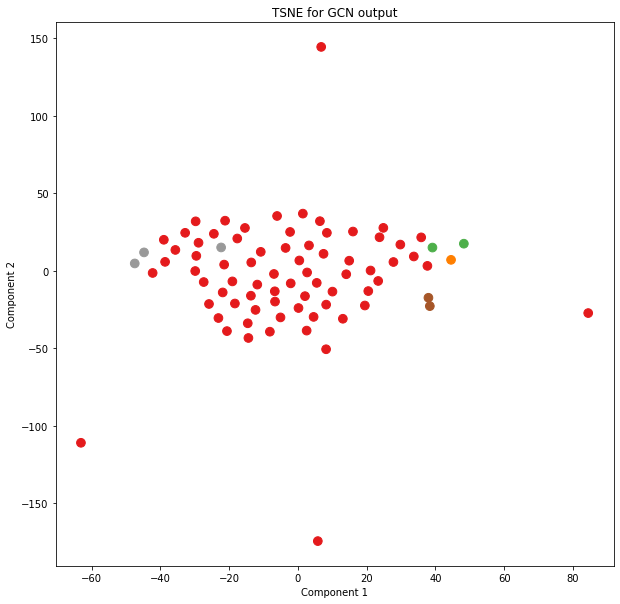

              precision    recall  f1-score   support

           0       0.86      0.98      0.92      2660
           1       0.97      0.63      0.77       242
           2       0.89      0.71      0.79        93
           3       0.96      0.71      0.82       111
           4       0.82      0.33      0.47       449

    accuracy                           0.86      3555
   macro avg       0.90      0.67      0.75      3555
weighted avg       0.86      0.86      0.84      3555



In [40]:
print('Best path - ', trainer_spectral.checkpoint_callbacks[0].best_model_path)
res_spectral = test_model(trainer_spectral.checkpoint_callbacks[0].best_model_path, ce_weights, __data__, is_spectral=True)

In [41]:
print(classification_report(res_spectral[res_spectral['true_label'] != 0]['pred_label'], res_spectral[res_spectral['true_label'] != 0]['true_label']))
res_spectral[res_spectral['true_label'] != 0]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        41
           1       0.97      0.96      0.96       160
           2       0.89      0.99      0.94        67
           3       0.96      1.00      0.98        79
           4       0.82      1.00      0.90       147

    accuracy                           0.90       494
   macro avg       0.73      0.79      0.76       494
weighted avg       0.83      0.90      0.86       494



,pred_label,true_label
0,2,2
2,1,1
3,1,1
4,1,1
11,3,3
...,...,...
3541,4,4
3543,4,4
3545,4,4
3547,4,4


In [42]:
res_spectral[(res_spectral['true_label'] != res_spectral['pred_label']) & (res_spectral['true_label'] != 0)]

,pred_label,true_label
162,0,4
327,0,4
450,0,1
522,0,4
580,0,4
640,2,1
663,0,4
672,0,4
678,1,2
726,0,4


<AxesSubplot:ylabel='Density'>

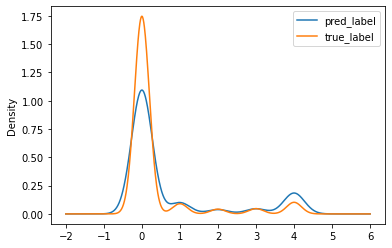

In [43]:
res_spectral.plot.kde()

<AxesSubplot:title={'center':'Spectral GCN'}, ylabel='Density'>

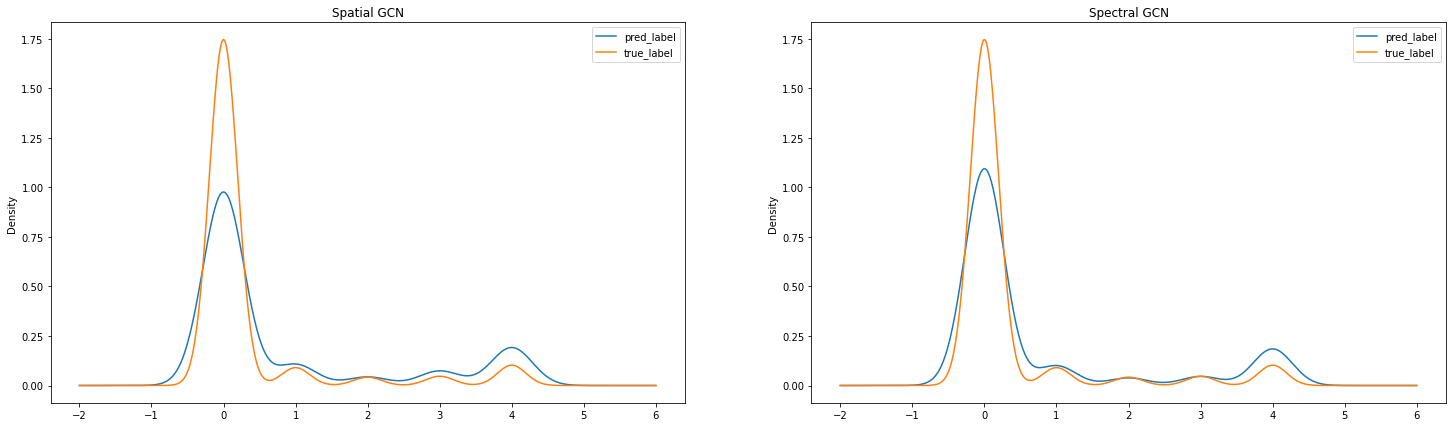

In [44]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25,7))
ax1.set_title('Spatial GCN')
ax2.set_title('Spectral GCN')
res_spatial.plot(kind='kde', ax=ax1)
res_spectral.plot(kind='kde', ax=ax2)

## Model Inference - Post Deployment

In [45]:
df_ocr_processed

,file_path,ie_file_path,image,txt,width,height,normalized_width,normalized_height,doc_xmin,doc_xmax,...,n_r_y2,n_r_x3,n_r_y3,n_r_x4,n_r_y4,resize_width,resize_height,text,label_names,label
0,../../../data/raw/train-1,../../../data/raw/train-2,X51005719917.jpg,X51005719917.txt,932,2679,767,2472,101,868,...,0.000000,0.621904,0.010922,0.349413,0.010922,720,1080,TAX INVOICE,OTHERS,0.0
1,../../../data/raw/train-1,../../../data/raw/train-2,X51005719917.jpg,X51005719917.txt,932,2679,767,2472,101,868,...,0.016990,0.658409,0.028722,0.320730,0.028722,720,1080,DOMINO'S PIZZA,OTHERS,0.0
2,../../../data/raw/train-1,../../../data/raw/train-2,X51005719917.jpg,X51005719917.txt,932,2679,767,2472,101,868,...,0.040049,0.816167,0.052994,0.168188,0.052994,720,1080,GST REF NO : 001694261248,OTHERS,0.0
3,../../../data/raw/train-1,../../../data/raw/train-2,X51005719917.jpg,X51005719917.txt,932,2679,767,2472,101,868,...,0.060680,0.786180,0.071602,0.183833,0.071602,720,1080,DOMINO'S PIZZA SEGAMBUT,OTHERS,0.0
4,../../../data/raw/train-1,../../../data/raw/train-2,X51005719917.jpg,X51005719917.txt,932,2679,767,2472,101,868,...,0.079693,0.857888,0.093851,0.121252,0.093851,720,1080,"D-08, M AVENUE, JLN 1 / 38A",OTHERS,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56891,../../../data/raw/test-1,NaN,X51009568881.jpg,X51009568881.txt,884,1678,769,1347,45,814,...,0.874536,0.475943,0.896808,0.386216,0.896808,720,1080,9.81,NaN,NaN
56892,../../../data/raw/test-1,NaN,X51009568881.jpg,X51009568881.txt,884,1678,769,1347,45,814,...,0.873794,0.706112,0.899035,0.615085,0.899035,720,1080,0.59,NaN,NaN
56893,../../../data/raw/test-1,NaN,X51009568881.jpg,X51009568881.txt,884,1678,769,1347,45,814,...,0.874536,0.966190,0.898293,0.859558,0.898293,720,1080,10.40,NaN,NaN
56894,../../../data/raw/test-1,NaN,X51009568881.jpg,X51009568881.txt,884,1678,769,1347,45,814,...,0.933927,0.958388,0.971789,0.006502,0.971789,720,1080,THANK YOU ! & PLEASE COME AGAIN !!,NaN,NaN


In [46]:
def plot_record_inf(df):
    assert len(df['file_path'].unique().tolist()) == 1, 'df must have only one document.'
    image = cv2.imread(os.path.join(df.iloc[0]['file_path'], df.iloc[0]['image']))
    for ind, row in df.iterrows():
        if row['label_pred'] != conf.LABEL['OTHERS']:
            image = cv2.rectangle(image, (int(row['x1']), int(row['y1'])), (int(row['x3']), int(row['y3'])), (255, 0, 0), 2)
            image = cv2.putText(image, row['label_names_pred'], (int(row['x1']), int(row['y1'])-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1, cv2.LINE_AA)
            if isinstance(row['label_names'], str):
                image = cv2.putText(image, row['label_names'], (int(row['x2']), int(row['y2'])-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)            
    fig = plt.figure(figsize=(30,15))
    plt.imshow(image)

def inference(df, model, verbose=True):
    model.eval()
    inf_df = copy.deepcopy(df)
    inf_df, graph_dict, graph, padded_adj_matrix, padded_features, adj_matrix, edge_index, features, data = Graph(inf_df).graph()
    y_hat = model(data.x, data.edge_index)
    y_hat = y_hat.cpu().detach().numpy()
    out = copy.deepcopy(y_hat)
    y_hat = np.argmax(y_hat, axis=1)
    inf_df['label_pred'] = list(y_hat)
    inf_df['label_names_pred'] = inf_df['label_pred'].apply(lambda x: conf.IND_LABEL[str(x)])
    if verbose:
        visualize_tsne(out, y_hat)
        plot_document_graph(inf_df, graph)
        plot_record_inf(inf_df)
    return inf_df

In [47]:
test_with_labels_df_ocr_processed = copy.deepcopy(df_ocr_processed[df_ocr_processed['is_test_with_label'] == 1])
test_with_labels_df_ocr_processed

,file_path,ie_file_path,image,txt,width,height,normalized_width,normalized_height,doc_xmin,doc_xmax,...,n_r_y2,n_r_x3,n_r_y3,n_r_x4,n_r_y4,resize_width,resize_height,text,label_names,label
917,../../../data/raw/train-1,../../../data/raw/train-2,X51006679222.jpg,X51006679222.txt,615,1347,547,1104,44,591,...,0.000000,0.031079,0.019022,0.005484,0.019022,720,1080,P,OTHERS,0.0
918,../../../data/raw/train-1,../../../data/raw/train-2,X51006679222.jpg,X51006679222.txt,615,1347,547,1104,44,591,...,0.018116,0.539305,0.075181,0.462523,0.075181,720,1080,8,OTHERS,0.0
919,../../../data/raw/train-1,../../../data/raw/train-2,X51006679222.jpg,X51006679222.txt,615,1347,547,1104,44,591,...,0.019022,0.586837,0.033514,0.542962,0.033514,720,1080,OZ,OTHERS,0.0
920,../../../data/raw/train-1,../../../data/raw/train-2,X51006679222.jpg,X51006679222.txt,615,1347,547,1104,44,591,...,0.081522,0.712980,0.108696,0.283364,0.108696,720,1080,EIGHT OUNCE,COMPANY,2.0
921,../../../data/raw/train-1,../../../data/raw/train-2,X51006679222.jpg,X51006679222.txt,615,1347,547,1104,44,591,...,0.115942,0.605119,0.144022,0.351005,0.144022,720,1080,COFFEE,COMPANY,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33505,../../../data/raw/train-1,../../../data/raw/train-2,X51006619496.jpg,X51006619496.txt,888,2160,723,1645,82,805,...,0.970213,0.964039,1.000000,0.005533,1.000000,720,1080,KEEP THE INVOICE FOR APPLICABLE RETURNS,OTHERS,0.0
33506,../../../data/raw/train-1,../../../data/raw/train-2,X51006619496.jpg,X51006619496.txt,888,2160,723,1645,82,805,...,0.336170,0.998617,0.359271,0.793914,0.359271,720,1080,RM3.79 S,OTHERS,0.0
33507,../../../data/raw/train-1,../../../data/raw/train-2,X51006619496.jpg,X51006619496.txt,888,2160,723,1645,82,805,...,0.367173,0.994467,0.390274,0.792531,0.390274,720,1080,RM2.85 S,OTHERS,0.0
33508,../../../data/raw/train-1,../../../data/raw/train-2,X51006619496.jpg,X51006619496.txt,888,2160,723,1645,82,805,...,0.398176,0.998617,0.421277,0.793914,0.421277,720,1080,RM4.90 S,OTHERS,0.0


In [48]:
test_df_ocr_processed = copy.deepcopy(df_ocr_processed[df_ocr_processed['is_test'] == 1])
test_df_ocr_processed

,file_path,ie_file_path,image,txt,width,height,normalized_width,normalized_height,doc_xmin,doc_xmax,...,n_r_y2,n_r_x3,n_r_y3,n_r_x4,n_r_y4,resize_width,resize_height,text,label_names,label
37554,../../../data/raw/test-1,NaN,X00016469670.jpg,X00016469670.txt,463,894,363,860,20,383,...,0.000000,0.829201,0.046512,0.214876,0.046512,720,1080,TAN CHAY YEE,NaN,NaN
37555,../../../data/raw/test-1,NaN,X00016469670.jpg,X00016469670.txt,463,894,363,860,20,383,...,0.080233,0.713499,0.109302,0.325069,0.109302,720,1080,*** COPY ***,NaN,NaN
37556,../../../data/raw/test-1,NaN,X00016469670.jpg,X00016469670.txt,463,894,363,860,20,383,...,0.108140,0.851240,0.132558,0.165289,0.132558,720,1080,OJC MARKETING SDN BHD,NaN,NaN
37557,../../../data/raw/test-1,NaN,X00016469670.jpg,X00016469670.txt,463,894,363,860,20,383,...,0.134884,0.735537,0.155814,0.300275,0.155814,720,1080,ROC NO: 538358-H,NaN,NaN
37558,../../../data/raw/test-1,NaN,X00016469670.jpg,X00016469670.txt,463,894,363,860,20,383,...,0.159302,0.787879,0.181395,0.231405,0.181395,720,1080,"NO 2 & 4, JALAN BAYU 4,",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56891,../../../data/raw/test-1,NaN,X51009568881.jpg,X51009568881.txt,884,1678,769,1347,45,814,...,0.874536,0.475943,0.896808,0.386216,0.896808,720,1080,9.81,NaN,NaN
56892,../../../data/raw/test-1,NaN,X51009568881.jpg,X51009568881.txt,884,1678,769,1347,45,814,...,0.873794,0.706112,0.899035,0.615085,0.899035,720,1080,0.59,NaN,NaN
56893,../../../data/raw/test-1,NaN,X51009568881.jpg,X51009568881.txt,884,1678,769,1347,45,814,...,0.874536,0.966190,0.898293,0.859558,0.898293,720,1080,10.40,NaN,NaN
56894,../../../data/raw/test-1,NaN,X51009568881.jpg,X51009568881.txt,884,1678,769,1347,45,814,...,0.933927,0.958388,0.971789,0.006502,0.971789,720,1080,THANK YOU ! & PLEASE COME AGAIN !!,NaN,NaN


In [ ]:
test_df_record_with_key = test_with_labels_df_ocr_processed[test_with_labels_df_ocr_processed['image'] == random.choice(test_with_labels_df_ocr_processed['image'].unique().tolist())]
res_with_key = inference(test_df_record_with_key, LitGCN.load_from_checkpoint(checkpoint_path=trainer_spectral.checkpoint_callbacks[0].best_model_path, ce_weights=ce_weights, is_spectral=True))

In [ ]:
test_df_record = test_df_ocr_processed[test_df_ocr_processed['image'] == random.choice(test_df_ocr_processed['image'].unique().tolist())]
res = inference(test_df_record, LitGCN.load_from_checkpoint(checkpoint_path=trainer_spectral.checkpoint_callbacks[0].best_model_path, ce_weights=ce_weights, is_spectral=True))